# COMP 551 — Assignment 3

Authors:
 - Bernier, Audréanne
 - Coull-Neveu, Ben
 - Trachsel-Bourbeau, Anjara

Imports

In [65]:
from torchvision import models, datasets, transforms
import torch
import torch.nn.functional as F
from torch.optim import Adam

import tqdm
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import os
%matplotlib inline

import pickle # to save models

In [66]:
# define plotting parameters
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.size'] = 14
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['legend.fontsize'] = 'medium'
plt.rcParams['legend.fancybox'] = False
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['figure.autolayout'] = True
plt.rcParams['axes.autolimit_mode'] = 'data'  # default, ensures autoscale uses data
plt.rcParams["font.family"] = "serif"


# set default save directory and parameters
SAVEDIR = './figures/'
MODELDIR = './models/'
os.makedirs(SAVEDIR, exist_ok=True)
os.makedirs(MODELDIR, exist_ok=True)
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'

CHECKLIST
- Implementation of data normalization (1 points)
- Implementation and training of MLP with no hidden layers (1 points)
- Implementation and training of MLP with one hidden layers and ReLU activation (3 points)
- Implementation and training of MLP with two hidden layers and ReLU activation (1 points)
- Implementation and training of the two hidden layers MLP with tanh activation (2 points)
- Implementation and training of the two hidden layers MLP with Leaky-ReLU activation (2 points)
- L1 regularization (2 points)
- L2 regularization (2 points)
- Train MLP without normalization (1 points)
- Correctly plot and compare the results of the 8 trained models above (5 points)
- Train the MLP with the 128 x 128 FashionMNIST data (1 points)
- Plot the results of the larger models, and compare classification performance and training time (2 points)
- Implement and train the CNN (2 points)
- Re-train the CNN with the 128 x 128 FashionMNIST data (1 points)
- Plot the results of the two CNN trained, and compare classification performance and training time to the best MLP. (4 points)
- Implement and train the pre-trained model with the trainable fully connected layer(s). (3 points)
- Plot the results of the pre-trained model, and compare its performance to the best MLP and regular CNN.(4 points)
- Run an experiment to justify the choice of fully connected layers for the pre-trained model, and show
supporting plots. (3 points)

You can report your findings either in the form of a table or a plot in the write-up. However, include in your
colab notebooks the plots of the test and train performance of the MLPs / CNN / pre-trained model as a function
of training epochs. This will allow you to see how much the network should be trained before it starts to overfit
to the training data.

Note 2: We expect you to provide plots/tables in your report that justifies your choice of hyperparameters
(the learning rates of the MLPs / CNNs / pretrained models, the architectural parameters of the CNNs and
pretrained models). You are not required to perform cross-validation in this project.

## Other functions

In [67]:
# CE loss
def cross_entropy_loss(y_true, y_pred):
    N = y_true.shape[0]
    # Clip predictions to avoid log(0)
    y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
    # Compute cross-entropy loss
    loss = -np.sum(y_true * np.log(y_pred)) / N
    return loss


# Accuracy
def evaluate_acc(y_true, y_pred):
    correct_predictions = np.argmax(y_true, axis=1) == np.argmax(y_pred, axis=1)
    return np.mean(correct_predictions)

In [68]:
def plot_gridsearch_results(
    tuning_results,
    L,
    batch_range,
    lr_range
):
    # plot heatmap of results
    heatmap_acc = pd.DataFrame(index=batch_range, columns=lr_range)
    for (batch_size, lr), acc in tuning_results.items():
        heatmap_acc.at[batch_size, lr] = acc[0]
        
    sns.heatmap(heatmap_acc.astype(float), annot=True, fmt=".3f", cmap="YlGnBu", cbar=False, square=True)
    plt.xlabel('Learning Rate')
    plt.ylabel('Batch Size')
    plt.grid(False)

    plt.title(f'Test Accuracy for MLP (L={L})')
    plt.savefig(os.path.join(SAVEDIR, f'gridsearch_mlp_L{L}.png'))
    plt.show()

    # make another one showing # epochs
    heatmap_epochs = pd.DataFrame(index=batch_range, columns=lr_range)
    for (batch_size, lr), acc in tuning_results.items():
        heatmap_epochs.at[batch_size, lr] = acc[1]
    sns.heatmap(heatmap_epochs.astype(int), annot=True, fmt="d", cmap="YlGnBu", cbar=False, square=True)
    plt.xlabel('Learning Rate')
    plt.ylabel('Batch Size')
    plt.grid(False)

    plt.title(f'Number of Epochs for MLP (L={L})')
    plt.savefig(os.path.join(SAVEDIR, f'gridsearch_mlp_epochs_L{L}.png'))
    plt.show()

# Implement MLP

In [69]:
# --- Activation functions and their derivatives ---
def softmax(z):
    z = np.atleast_2d(z)  # make sure z is 2D
    e_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return e_z / e_z.sum(axis=1, keepdims=True)

def relu(z, deriv=False):
    if deriv:
        return np.where(z > 0, 1, 0)
    return np.maximum(0, z)

def tanh(z, deriv=False):
    if deriv:
        return 1 - np.tanh(z)**2
    return np.tanh(z)

def leaky_relu(z, l=0.01, deriv=False):
    if deriv:
        return np.where(z > 0, 1, l)
    return np.maximum(0, z) + l * np.minimum(0, z)

In [70]:
# --- Function to Compute Gradient ---
def gradient(x, # N x D
             y, # N x C
             params, # Replaces explicit params below
            #  w, # M2 x C 
            #  v1 = None, # D x M1
            #  v2=None, # M1 x M2
             h = None,  # hidden layer activations (for L=2)
             L=0
             ):    
    # output layer (CE loss and softmax activation)
    N,D = x.shape

    # -- 0 hidden layers --
    # yh = softmax(WX)
    if L==0:
        w, b = params
        yh = softmax(np.dot(x, w) + b)  # N x C

        # compute dW = (yh - y)x /N
        dy = yh - y  # N x C
        dw = np.dot(x.T, dy)/N  # D x C
        db = np.mean(dy, axis=0) # C

        return dw, db

    # -- 1 hidden layer --
    # yh = softmax(W h(V1X)) with h = ReLU
    elif L==1:
        try:
            w, b, v1, c1 = params
        except ValueError:
            raise ValueError("Expected 4 parameters for L=1: w, b, v1, c1")
        # assert v1 is not None, "v1 must be provided for L=1"
        
        # forward pass
        q = np.dot(x, v1) + c1  # N x M1
        z = h(q)  # N x M1 (general activation!)
        yh = softmax(np.dot(z, w) + b)  # N x C

        # compute dW = (yh - y)z /N
        dy = yh - y  # N x C
        dw = np.dot(z.T, dy)/N  # M1 x C

        # compute dV1 = (yh-y)W dq x /N where dq = ReLU derivative
        dq = h(q, deriv=True)  # N x M1 (derivative of of activation function)
        dz = np.dot(dy, w.T)  # N x M1
        dv = np.dot(x.T, dz * dq)/N  # D x M1
        dc = np.mean(dz * dq, axis=0)
        db = np.mean(dy, axis=0)
        
        return dw, db, dv, dc

    # -- 2 hidden layers --
    # yh = softmax(W h(V2 g(V1 X))) with g = h = {ReLU, tanh, or leaky ReLU}
    elif L==2:
        try:
            w, b, v1, c1, v2, c2 = params
        except ValueError:
            raise ValueError("Expected 6 parameters for L=2: w, b, v1, c1, v2, c2")
        # assert v1 is not None and v2 is not None and h is not None, "v1, v2, and h must be provided for L=2"
        
        # forward pass
        q1 = np.dot(x, v1) + c1  # N x M1
        z1 = h(q1)  # N x M1
        q2 = np.dot(z1, v2) + c2  # N x M2
        z2 = h(q2)  # N x M2
        yh = softmax(np.dot(z2, w) + b)  # N x C

        # compute dW = (yh - y)z2 /N
        dy = yh - y  # N x C
        dw = np.dot(z2.T, dy)/N  # M2 x C

        # compute dV2 = (yh - y)W dq2 z1 /N where dq2 depends on h
        dq2 = h(q2, deriv=True) # dh/dq2, depends on activation function
        dz2 = np.dot(dy, w.T)  # N x M2
        dv2 = np.dot(z1.T, dz2 * dq2)/N  # M1 x M2

        # compute dV1 = (yh - y)W dq2 V2 dq1 x /N  where dq1 depends on h
        dq1 = h(q1, deriv=True)  # dh/dq1, depends on activation function
        dz1 = np.dot(dz2 * dq2, v2.T)  # N x M1
        dv1 = np.dot(x.T, dz1 * dq1)/N  # D x M1
        db = np.mean(dy, axis=0)
        dc2 = np.mean(dz2 * dq2, axis=0)
        dc1 = np.mean(dz1 * dq1, axis=0)
        
        return dw, db, dv1, dc1, dv2, dc2

In [71]:
class MLP:
    """
    Supports L = 0,1,2 hidden layers.

    Constructor takes:
    h = hidden activation function (same for all hidden layers)
    L = number of hidden layers
    M = number of hidden units, iterable (each element corresponds to a layer)
    
    -> Weights and biases are initialized randomly
    """

    def __init__(self, h=None, L=1, M=64, D=None, C=10, l1_reg=0, l2_reg=0): 
        self.h = h if h is not None else lambda x: x # default identity
        self.L = L
        self.l1_reg = l1_reg
        self.l2_reg = l2_reg
        assert l1_reg == 0 or l2_reg == 0, "Only one of l1_reg or l2_reg can be non-zero."
        
        if isinstance(M, int):
            self.M = [M] * L  # same num of units in each layer
        else:
            assert len(M) == L, "Length of M must equal L"
            self.M = M
        
        # Initialize weights & biases depending on # of layers (L)
        assert D is not None, "Need number of features"
        if L == 0:  # no hidden layer
            self.w = np.random.randn(D, C) * 0.1
            self.b = np.zeros(C)
        elif L == 1:  # 1 hidden layer
            self.v = np.random.randn(D, self.M[0]) * 0.1  # 1st hidden layer, D x M
            self.c = np.zeros(self.M[0])
            self.w = np.random.randn(self.M[0], C) * 0.1  # output layer, M x C
            self.b = np.zeros(C)
        elif L == 2:  # 2 hidden layers
            self.v1 = np.random.randn(D, self.M[0]) * 0.1  # 1st hidden layer, D x M1
            self.c1 = np.zeros(self.M[0])
            self.v2 = np.random.randn(self.M[0], self.M[1]) * 0.1  # 2nd hidden layer, M1 x M2
            self.c2 = np.zeros(self.M[1])
            self.w = np.random.randn(self.M[1], C) * 0.1  # output layer, M2 x C
            self.b = np.zeros(C)


    def fit(self, x, y, optimizer):
        # Put current weights into a list (for gradient function)
        if self.L == 0:
            params0 = [self.w, self.b]
        elif self.L == 1:
            params0 = [self.w, self.b, self.v, self.c]
        elif self.L == 2:
            params0 = [self.w, self.b, self.v1, self.c1, self.v2, self.c2]
        
        # Define gradient function for optimizer
        gradient_fn = lambda x, y, p: gradient(x, y, p, h=self.h, L=self.L)  

        # Run optimizer
        self.params = optimizer.run(gradient_fn, x=x, y=y, params=params0, l1_reg=self.l1_reg, l2_reg=self.l2_reg)
        return self
    

    def predict(self, x):
        if self.L == 0:
            w, b = self.params
            yh = softmax(np.dot(x, w) + b)  # N x C
        elif self.L == 1:
            w, b, v, c = self.params
            q = np.dot(x, v) + c  # N x M
            z = self.h(q)  # N x M
            yh = softmax(np.dot(z, w) + b)  # N x C
        elif self.L == 2:
            w, b, v1, c1, v2, c2 = self.params
            q1 = np.dot(x, v1) + c1  # N x M1
            z1 = self.h(q1)  # N x M1
            q2 = np.dot(z1, v2) + c2  # N x M2
            z2 = self.h(q2)  # N x M2
            yh = softmax(np.dot(z2, w) + b)  # N x C
        return yh

In [72]:
# Gradient Descent Optimizer
class GradientDescent:
    
    def __init__(self, learning_rate=.001, epsilon=1e-8, max_iters=1, record_grad=False):
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.max_iters = max_iters
        self.record_grad = record_grad
        self.history_grad = []
        
    def run(self, gradient_fn, x, y, params, l1_reg=0, l2_reg=0):
        """
        This does GD for x and y (which are already a SINGLE BATCH of the data)

        gradient_fn: function that computes gradients
        params: list of weight matrices, e.g., [w, b, v1, c1, v2, c2] for L=2
        """
        assert l1_reg == 0 or l2_reg == 0, "Only one of l1_reg or l2_reg can be non-zero."
        
        norms = np.array([np.inf])
        t=0

        while np.any(norms > self.epsilon) and t < self.max_iters:
            grad = gradient_fn(x, y, params)
            
            
            norms = np.array([np.linalg.norm(g) for g in grad])
            # record gradients if desired
            if self.record_grad:
                total_norm = np.sqrt(np.sum(norms**2))
                self.history_grad.append(total_norm)
                            
            for p in range(len(params)):
                if np.ndim(params[p]) > 1: # so not biases
                    params[p] -= self.learning_rate * (grad[p] + l1_reg * np.sign(params[p]) + l2_reg * params[p])
                else:
                    params[p] -= self.learning_rate * grad[p]
            t += 1
    
        return params

In [93]:
# --- Train on batches over epochs ---
def train_on_batches(model, optimizer, epochs, train_loader, val_loader=None, early_stopping_patience=3, num_classes=10, plot_train=False, verbose=True,
                     save_best_weights=True, save_fig=False, save_name=''):
    """
    Returns dictionary with:
    'grad': grad, # keeping all batches for now... can change later for space optimization
    'train_loss': train_loss,
    'val_loss': val_loss,
    'val_acc': val_acc,
    'best_weights': best_weights,
    'fig': fig if plot_train else None,
    'ax': ax if plot_train else None   
    """
    
    grad, train_loss, val_loss = {}, {}, {}
    val_acc = {}
    best_val_loss = np.inf
    best_weights = None
    
    for epoch in range(epochs):
        grad[epoch], train_loss[epoch], val_loss[epoch] = [], [], []
        batch_num = len(train_loader)
        
        # Go through batches
        for i, (b_x, b_y) in enumerate(train_loader):
            # flatten images
            b_x = b_x.view(b_x.size(0), -1).numpy()
            # one-hot encode labels
            y_batch = np.eye(num_classes)[b_y.numpy()]
            # fit model on this batch
            model.fit(b_x, y_batch, optimizer)
            try:
                grad[epoch].append(optimizer.history_grad[-1])
            except:
                grad[epoch] = 0
            
            # compute loss on this batch
            yhat_batch = model.predict(b_x)
            batch_loss = cross_entropy_loss(y_batch, yhat_batch)
            train_loss[epoch].append(batch_loss)
            print(f"Epoch {epoch+1}/{epochs}, Batch {i+1}/{batch_num} === Loss: {batch_loss:.3} {' '*10}", end='\r')
            # end of batch loop for training set
        
        avg_loss = np.mean(train_loss[epoch])
        avg_grad = np.mean(grad[epoch])
        if verbose:    
            print(f"Epoch {epoch+1}/{epochs} === Train Loss: {avg_loss:.3} | Avg Grad Norm: {avg_grad:.3} {' '*10}")
        
        # loop over validation batches to compute val loss
        if val_loader is not None:
            val_losses, val_accs = [], []
            for j, (val_x, val_y) in enumerate(val_loader):
                val_x = val_x.view(val_x.size(0), -1).numpy()
                y_val = np.eye(num_classes)[val_y.numpy()]
                yhat_val = model.predict(val_x)
                val_batch_loss = cross_entropy_loss(y_val, yhat_val)
                val_losses.append(val_batch_loss)
                # getting validation accuracy at current epoch
                yh = model.predict(val_x)
                val_accs.append(evaluate_acc(y_val, yh))
                if verbose:
                    print(f"Validation batch {j+1}/{len(val_loader)} === Val Loss: {val_batch_loss:.3} {' '*10}", end='\r')
                # end of batch loop for validation set
            val_loss[epoch] = np.mean(val_losses)
            val_acc[epoch] = np.mean(val_accs)
            
            if verbose:
                print(f"Epoch {epoch+1}/{epochs} === Train Loss: {avg_loss:.3} | Val Loss: {val_loss[epoch]:.3} | Avg Grad Norm: {avg_grad:.3} {' '*10}")

            if val_loss[epoch] < best_val_loss:
                best_val_loss = val_loss[epoch]
                best_weights = model.params.copy()  # save best weights
                if verbose:
                    print('Yay! New best validation loss!')
            
            # early stopping condition: Checking if validation loss increased compared to the previous n epochs
            if epoch >= early_stopping_patience:
                if all(val_loss[epoch] >= val_loss[epoch - p - 1] for p in range(early_stopping_patience)):
                    print(f"Early stopping at epoch {epoch+1} due to no improvement in validation loss over the last {early_stopping_patience} epochs.")
                    break
        # end of validation part
        
        if verbose:
            print('-'*20, end='\n\n')
    
    # Plot training and validation loss and accuracy
    if plot_train:
        fig, ax = plt.subplots(figsize=(9, 6))
        
        # plot loss
        ax.plot([np.mean(train_loss[e]) for e in train_loss.keys()], label='Train Loss')
        if val_loader is not None:
            ax.plot([val_loss[e] for e in val_loss.keys()], label='Val Loss')
        
        # Labels
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Cross-Entropy Loss')
        ax.set_title('Training and Validation Loss over Epochs')
        
        # second axis for validation accuracy
        ax1 = ax.twinx()
        ax1.plot(val_acc.keys(), val_acc.values(), color='green', label='Val Accuracy', linestyle='--')
        ax1.set_ylabel('Validation Accuracy', color='green')
        ax1.tick_params(axis='y', labelcolor='green')
        ax1.set_ylim(0, 1)

        # Combine legends
        lines, labels = ax.get_legend_handles_labels()
        lines2, labels2 = ax1.get_legend_handles_labels()

        # Place legend below the plot as horizontal
        ax1.legend(lines + lines2, labels + labels2, loc='upper center', 
               bbox_to_anchor=(0.5, -0.15), ncol=3)
        # ax1.legend(lines + lines2, labels + labels2, loc='upper right')

        if save_fig:
            plt.savefig(os.path.join(SAVEDIR, f'epoch_training_evolution_{save_name}.png'), bbox_inches='tight')
        plt.show()
        
    if save_best_weights and best_weights is not None:
        if verbose:
            print('Setting model to best weights found (lowest validation loss)')
        model.params = best_weights  # set model to best weights found!

    return {
        'grad': grad, # keeping all batches for now... can change later for space optimization
        'train_loss': train_loss, 
        'val_loss': val_loss,
        'val_acc': val_acc,
        'best_weights': best_weights,
        'fig': fig if plot_train else None,
        'ax': ax if plot_train else None
        }

# Dataset

## Compute Statistics

In [74]:
# Compute mean and std of train dataset (for normalization)
dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
images, labels = dataset.data, dataset.targets
images_scaled = dataset.data.float() / 255.0  # convert to float and scale to [0,1]

# Compute mean and std over all training set (since greyscale images)
MEAN = images_scaled.mean()
STD = images_scaled.std()
print(MEAN, STD)

tensor(0.2860) tensor(0.3530)


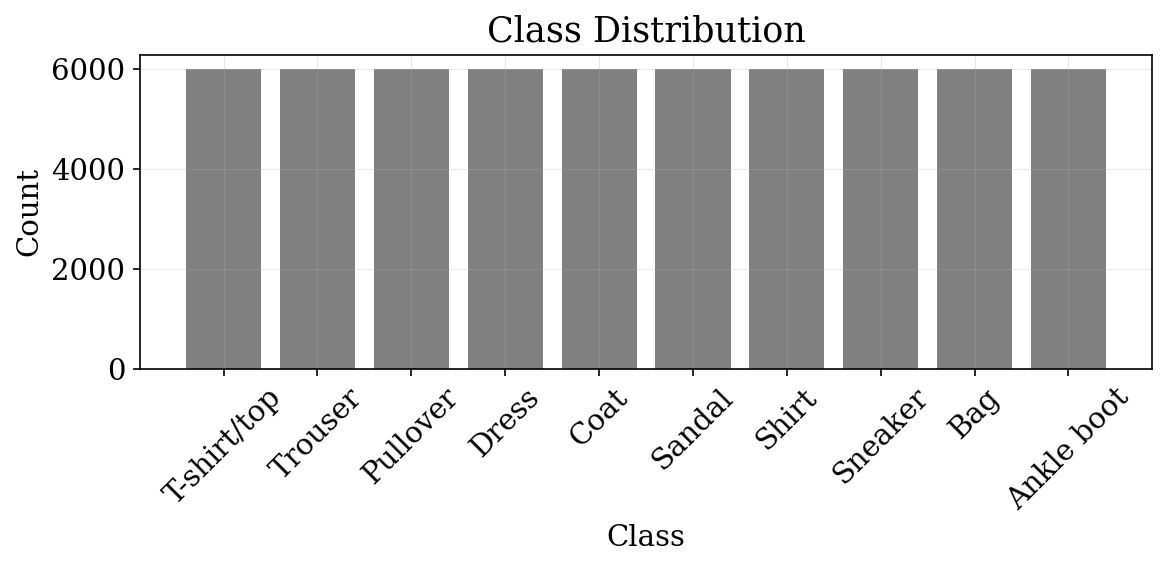

In [75]:
# Class distribution
plt.figure(figsize=(8,4))
plt.title("Class Distribution")

plt.bar(torch.arange(10), labels.bincount(), color='grey')

plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(torch.arange(10), dataset.classes, rotation=45)

plt.tight_layout()
plt.savefig(os.path.join(SAVEDIR, 'class_distribution.png'))
plt.show()

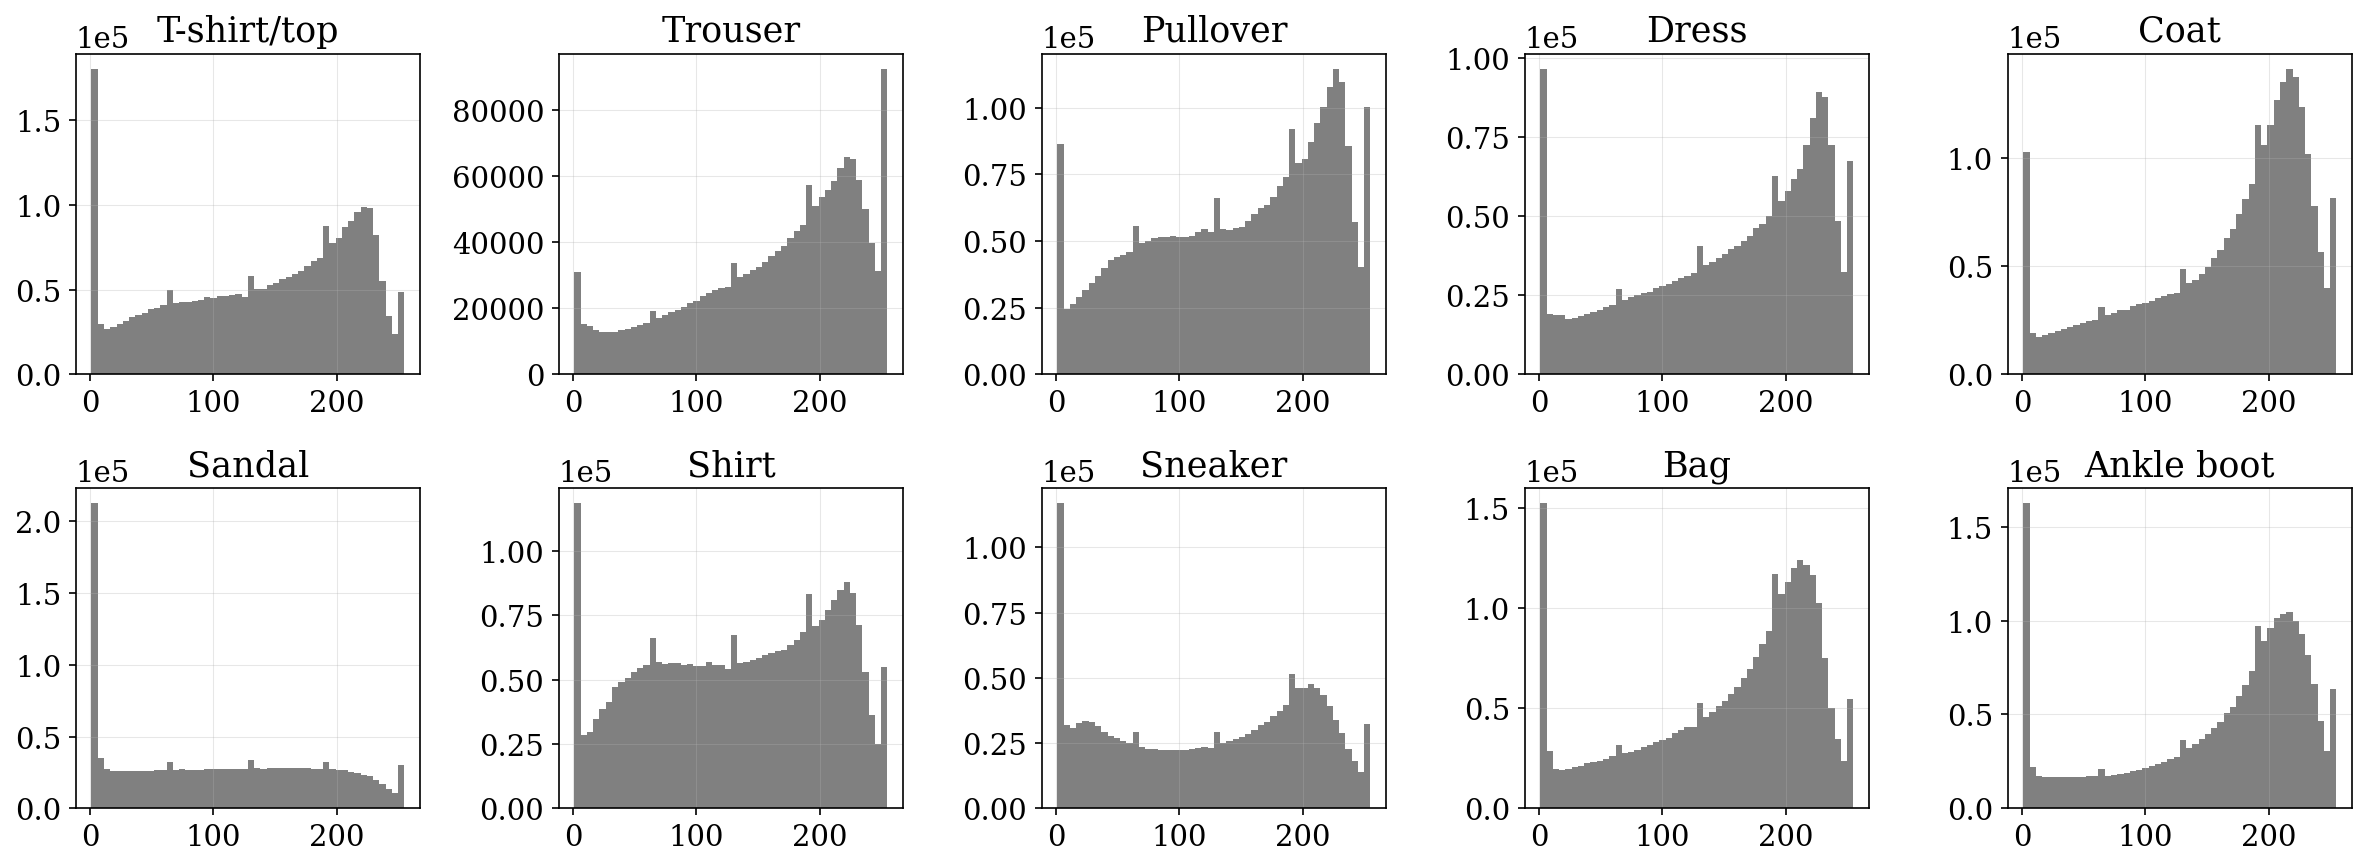

In [76]:
fig, axes = plt.subplots(2, 5, figsize=(16, 6))
axes = axes.flatten()

for class_id in range(10):
    ax = axes[class_id]
    
    class_pixels = images[labels == class_id].numpy().flatten()

    nonzero = class_pixels[class_pixels > 0]  # excluding pixel value 0 otherwise they dominate
    ax.hist(nonzero, bins=50, color='grey')
    ax.set_title(dataset.classes[class_id])

    formatter = ScalarFormatter()
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1,5))
    ax.yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.savefig(os.path.join(SAVEDIR, 'class_pixel_distributions.png'))
plt.show()

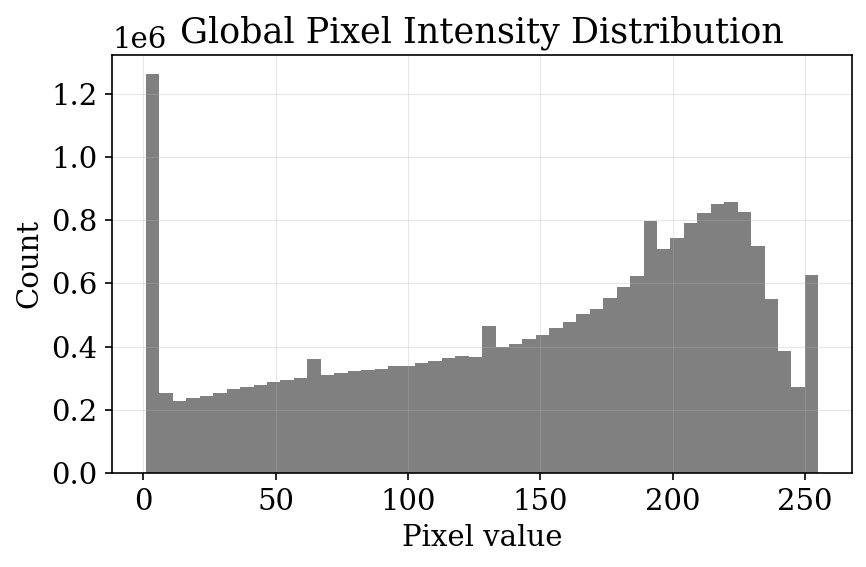

In [77]:
# Global pixel distribution
all_pixels = images.numpy().flatten()
all_pixels_nonzero = all_pixels[all_pixels > 0]  # exclude 0 pixel values

plt.figure(figsize=(6,4))
plt.title("Global Pixel Intensity Distribution")

plt.hist(all_pixels_nonzero, bins=50, color='grey')

plt.xlabel("Pixel value")
plt.ylabel("Count")

plt.savefig(os.path.join(SAVEDIR, 'global_pixel_distribution.png'))
plt.show()

## Load Data (normalized)

Get datasets

In [78]:
# Function to load the FashionMNIST dataset with specific transforms
def get_datasets(use_validation=True, transform=None):
    train_dataset = datasets.FashionMNIST(
        root='./data', 
        train=True, 
        download=True, 
        transform=transform
        )
    test_dataset = datasets.FashionMNIST(
        root='./data', 
        train=False, 
        download=True, 
        transform=transform
        )

    # validation if wanted!
    val_dataset = None
    if use_validation:
        val_frac = 0.1
        num_train = len(train_dataset)
        val_size = int(val_frac * num_train)
        train_size = num_train - val_size
        val_dataset, train_dataset = torch.utils.data.random_split(
            train_dataset,
            [val_size, train_size]
        ) 
    return train_dataset, val_dataset, test_dataset
    # Note that train_dataset and val_dataset are Subset objects now!!!

In [79]:
# Get a normalized dataset
USE_VALIDATION = True
transform = transforms.Compose([transforms.ToTensor(), # scales to [0,1]
                            transforms.Normalize((MEAN,), (STD,))  # mean 0, std 1
                            ])
train_dataset, val_dataset, test_dataset = get_datasets(USE_VALIDATION, transform)

# Data info
print('\nDataset information:')
print('Training samples:', len(train_dataset))
if USE_VALIDATION:
    print('Validation samples:', len(val_dataset))
print('Test samples:', len(test_dataset))

print('\nUnderlying dataset info:')
print(train_dataset.dataset.classes)
print(train_dataset.dataset.data.shape)
print(train_dataset.dataset.targets.shape)


Dataset information:
Training samples: 54000
Validation samples: 6000
Test samples: 10000

Underlying dataset info:
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
torch.Size([60000, 28, 28])
torch.Size([60000])


Get loaders

In [80]:
# Function to get loaders
def get_data_loaders(train_dataset, test_dataset, val_dataset=None, batch_size=512, batch_tests=False, use_validation=True):
    # Get loaders (makes batches for later)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True
        )
    test_dataset_size = len(test_dataset)
    test_loader = torch.utils.data.DataLoader(
        test_dataset, 
        batch_size=batch_size if batch_tests else test_dataset_size, 
        shuffle=False
    )

    if USE_VALIDATION:
        val_loader = torch.utils.data.DataLoader(
            val_dataset,
            batch_size=batch_size,
            shuffle=False
        )
    
    return (train_loader, val_loader, test_loader) if use_validation else (train_loader, test_loader)

In [81]:
# Get loaders for normalized dataset, with batches
BATCH_SIZE = 512
train_loader, val_loader, test_loader = get_data_loaders(train_dataset, test_dataset, val_dataset, BATCH_SIZE, USE_VALIDATION)

# looking at data in 1 batch
images0, labels0 = next(iter(train_loader))  # get first batch``
print(images0.shape)  # (batch_size, 1, 28, 28)
print(labels0.shape)  # (batch_size,)
# same for test loader

num_classes = len(train_dataset.dataset.classes)

torch.Size([512, 1, 28, 28])
torch.Size([512])


# MLP Experiments

## 0 - Tune Hyperparameters

** Note: the gridsearch cells are commented out to prevent accidentally excuting the code as it takes a long time to run. We ran it once, saved the results, and are now loading them in.

In [82]:
# Define hyperparameter ranges to search
num_hyper = 5
lowest_batch_log = 4  # 2^4 = 16
highest_batch_log = lowest_batch_log + num_hyper -1

batch_range, lr_range = np.logspace(lowest_batch_log, highest_batch_log, num=num_hyper, base=2, dtype=int), np.linspace(0.01, 0.5, num_hyper)

print("Batch sizes to try:", batch_range)
print("Learning rates to try:", lr_range)
# could add: number of epochs, number of iterations within GD

Batch sizes to try: [ 16  32  64 128 256]
Learning rates to try: [0.01   0.1325 0.255  0.3775 0.5   ]


In [83]:
# LOADING GRID SEARCH RESULTS (run to avoid re-running grid search)
with open(os.path.join(MODELDIR, 'grid_search_results.pkl'), 'rb') as f:
    grid_search_results = pickle.load(f)
    
tuning_results0 = grid_search_results['L0']
tuning_results1 = grid_search_results['L1']
tuning_results2 = grid_search_results['L2']

best_hyper0 = grid_search_results['L0_best']
best_hyper1 = grid_search_results['L1_best']
best_hyper2 = grid_search_results['L2_best']

In [84]:
# # --- Grid search for L = 0 ---
# tuning_results0 = {} # dict to store test accuracies
# epochs = 50

# for batch_size in batch_range:
#     batch_size = int(batch_size)  # casting to ensure it's a python int

#     # get loaders for this batch size (using normalized data)
#     train_loader, val_loader, test_loader = get_data_loaders(train_dataset=train_dataset, 
#                                                                 test_dataset=test_dataset, 
#                                                                 val_dataset=val_dataset, 
#                                                                 batch_size=batch_size, 
#                                                                 use_validation=USE_VALIDATION)
    
#     # loop over learning rates
#     for lr in lr_range:
#         # define model and optimizer (use same model params as for part 1)
#         model = MLP(h=relu, L=0, M=256, D=28*28)
#         optimizer = GradientDescent(learning_rate=lr)
        
#         results = train_on_batches(model, 
#                                    optimizer, 
#                                    epochs=epochs, 
#                                    train_loader=train_loader, 
#                                    val_loader=val_loader, 
#                                    early_stopping_patience=5,
#                                    num_classes=num_classes, 
#                                    plot_train=False, 
#                                    verbose=False, 
#                                    save_best_weights=True)
        
#         # Evaluate on test set
#         test_acc = []
#         for test_x, test_y in test_loader:
#             test_x = test_x.view(test_x.size(0), -1).numpy()
#             y_test = np.eye(num_classes)[test_y.numpy()]
#             yh_test = model.predict(test_x)
#             test_acc.append(evaluate_acc(y_test, yh_test))
#         avg_test_acc = np.mean(test_acc)
        
#         epoch = len(results["train_loss"])
        
#         print(f"Batch Size: {batch_size}, Learning Rate: {lr:.3} === Test Accuracy: {avg_test_acc:.3}")
#         tuning_results0[(batch_size, lr)] = [avg_test_acc, epoch, model]
        
# # finding best hyperparameters
# best_hyper0 = max(tuning_results0.items(), key=lambda x: x[1][0])
# best_model0 = best_hyper0[1][2]
# print(f"Best hyperparameters for L=0: Batch Size = {best_hyper0[0][0]}, Learning Rate = {best_hyper0[0][1]} with Test Accuracy = {best_hyper0[1][0]:.3} over {best_hyper0[1][1]} epochs")

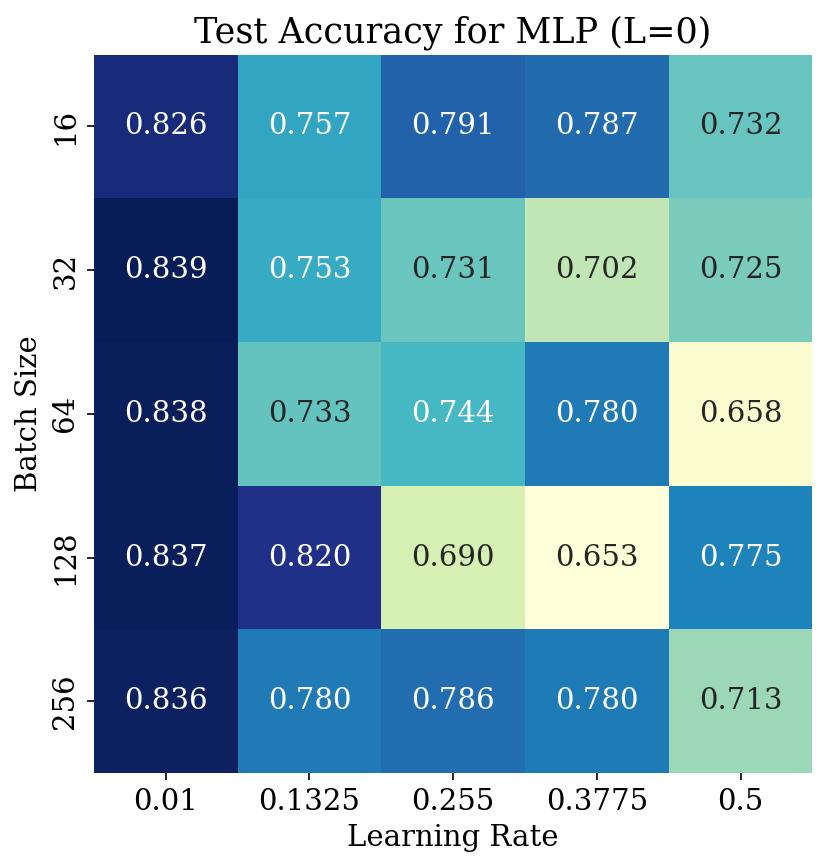

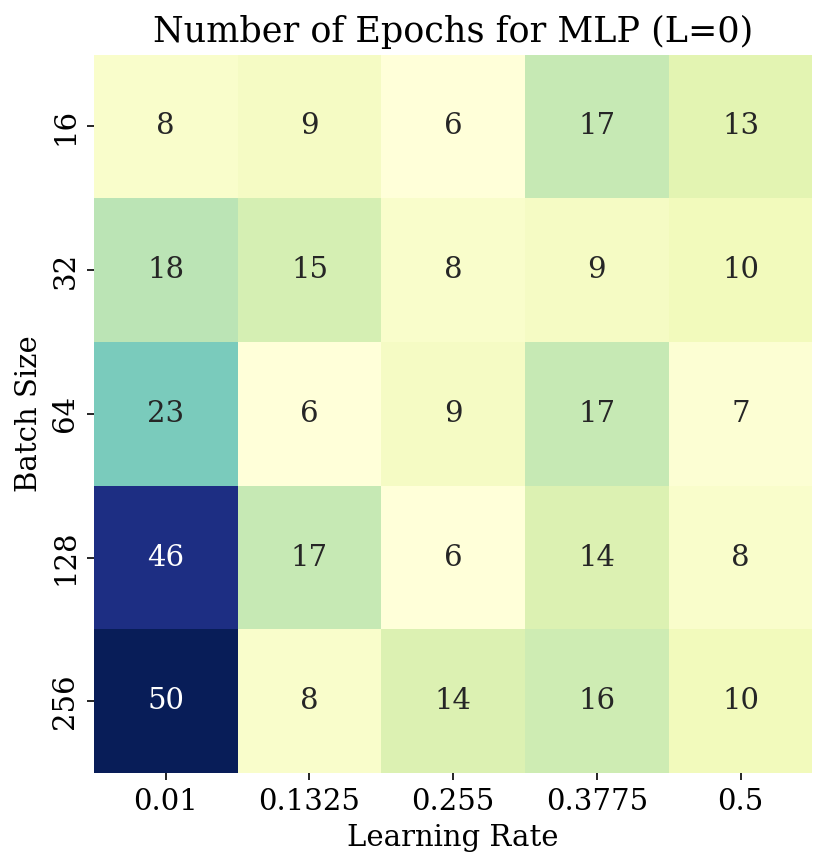

In [85]:
plot_gridsearch_results(tuning_results0, L=0, batch_range=batch_range, lr_range=lr_range)

In [86]:
# # --- Grid search for L = 1 ---
# tuning_results1 = {} # dict to store test accuracies
# epochs = 50

# for batch_size in batch_range:
#     batch_size = int(batch_size)  # casting to ensure it's a python int

#     # get loaders for this batch size (using normalized data)
#     train_loader, val_loader, test_loader = get_data_loaders(train_dataset=train_dataset, 
#                                                                 test_dataset=test_dataset, 
#                                                                 val_dataset=val_dataset, 
#                                                                 batch_size=batch_size, 
#                                                                 use_validation=USE_VALIDATION)
    
#     # loop over learning rates
#     for lr in lr_range:
#         # define model and optimizer (use same model params as for part 1)
#         model = MLP(h=relu, L=1, M=256, D=28*28)
#         optimizer = GradientDescent(learning_rate=lr)
        
#         results = train_on_batches(model, 
#                                    optimizer, 
#                                    epochs=epochs, 
#                                    train_loader=train_loader, 
#                                    val_loader=val_loader, 
#                                    early_stopping_patience=3,
#                                    num_classes=num_classes, 
#                                    plot_train=False, 
#                                    verbose=False, 
#                                    save_best_weights=True)
        
#         # Evaluate on test set
#         test_acc = []
#         for test_x, test_y in test_loader:
#             test_x = test_x.view(test_x.size(0), -1).numpy()
#             y_test = np.eye(num_classes)[test_y.numpy()]
#             yh_test = model.predict(test_x)
#             test_acc.append(evaluate_acc(y_test, yh_test))
#         avg_test_acc = np.mean(test_acc)
        
#         epoch = len(results["train_loss"])
        
#         print(f"Batch Size: {batch_size}, Learning Rate: {lr:.3} === Test Accuracy: {avg_test_acc:.3}")
#         tuning_results1[(batch_size, lr)] = [avg_test_acc, epoch, model]
        
# # finding best hyperparameters
# best_hyper1 = max(tuning_results1.items(), key=lambda x: x[1][0])
# best_model1 = best_hyper1[1][2]
# print(f"Best hyperparameters for L=1: Batch Size = {best_hyper1[0][0]}, Learning Rate = {best_hyper1[0][1]} with Test Accuracy = {best_hyper1[1][0]:.3} over {best_hyper1[1][1]} epochs")

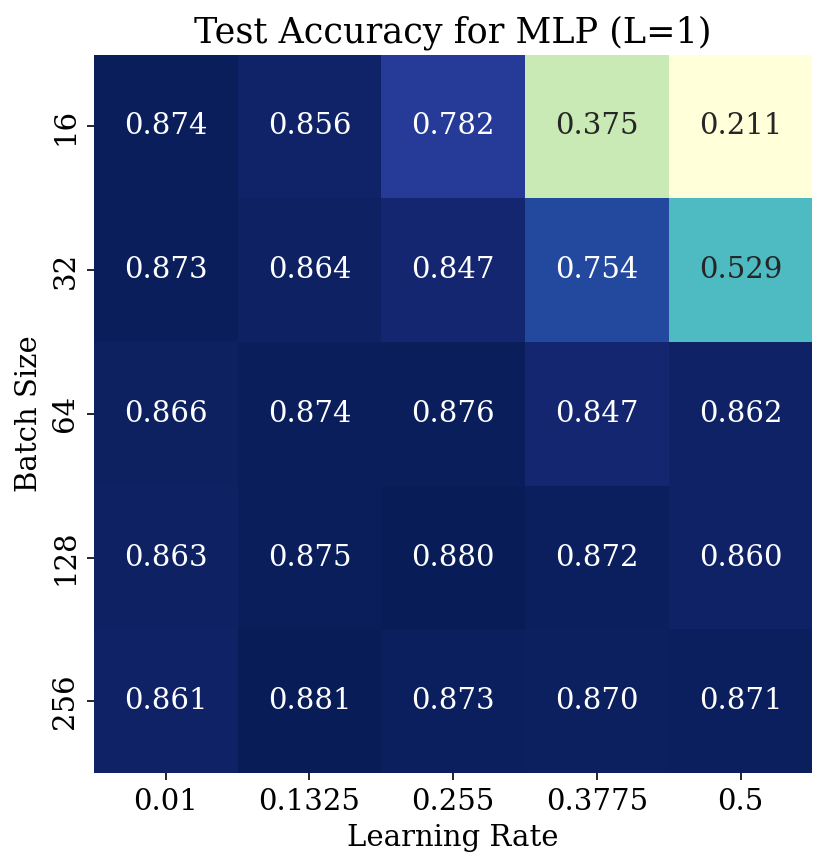

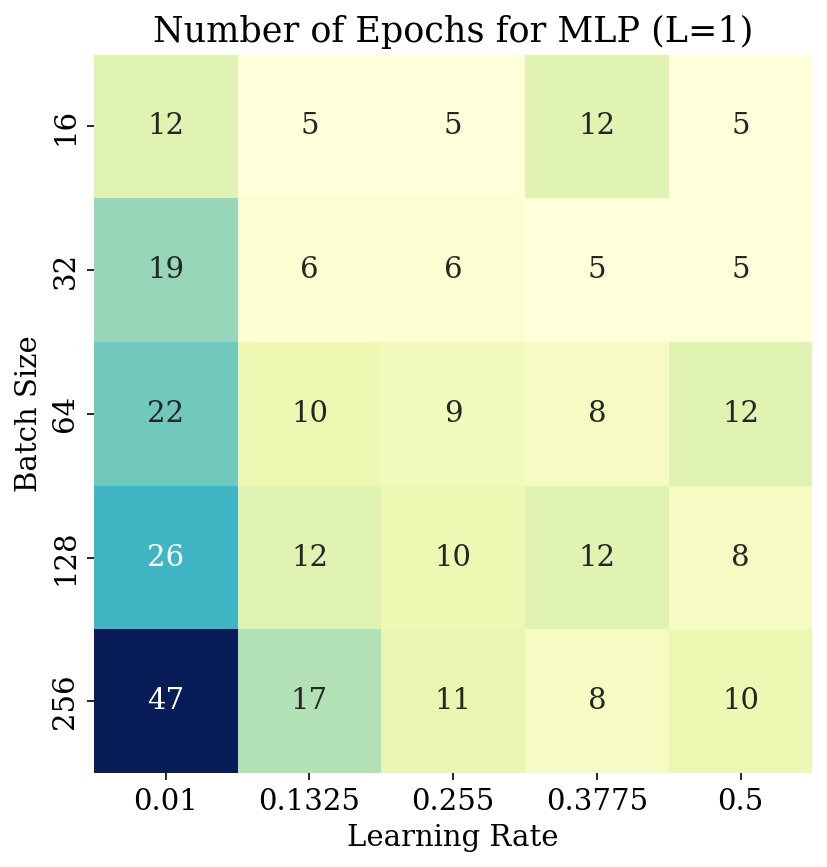

In [87]:
plot_gridsearch_results(tuning_results1, L=1, batch_range=batch_range, lr_range=lr_range)

In [88]:
# # --- Grid search for L = 2 ---
# tuning_results2 = {} # dict to store test accuracies
# epochs = 50

# for batch_size in batch_range:
#     batch_size = int(batch_size)  # casting to ensure it's a python int

#     # get loaders for this batch size (using normalized data)
#     train_loader, val_loader, test_loader = get_data_loaders(train_dataset=train_dataset, 
#                                                                 test_dataset=test_dataset, 
#                                                                 val_dataset=val_dataset, 
#                                                                 batch_size=batch_size, 
#                                                                 use_validation=USE_VALIDATION)
    
#     # loop over learning rates
#     for lr in lr_range:
#         # define model and optimizer (use same model params as for part 1)
#         model = MLP(h=relu, L=2, M=256, D=28*28)
#         optimizer = GradientDescent(learning_rate=lr)
        
#         results = train_on_batches(model, 
#                                    optimizer, 
#                                    epochs=epochs, 
#                                    train_loader=train_loader, 
#                                    val_loader=val_loader, 
#                                    early_stopping_patience=3,
#                                    num_classes=num_classes, 
#                                    plot_train=False, 
#                                    verbose=False, 
#                                    save_best_weights=True)
        
#         # Evaluate on test set
#         test_acc = []
#         for test_x, test_y in test_loader:
#             test_x = test_x.view(test_x.size(0), -1).numpy()
#             y_test = np.eye(num_classes)[test_y.numpy()]
#             yh_test = model.predict(test_x)
#             test_acc.append(evaluate_acc(y_test, yh_test))
#         avg_test_acc = np.mean(test_acc)
        
#         epoch = len(results["train_loss"])
        
#         print(f"Batch Size: {batch_size}, Learning Rate: {lr:.3} === Test Accuracy: {avg_test_acc:.3}")
#         tuning_results2[(batch_size, lr)] = [avg_test_acc, epoch, model]
        
# # finding best hyperparameters
# best_hyper2 = max(tuning_results2.items(), key=lambda x: x[1][0])
# best_model2 = best_hyper2[1][2]
# print(f"Best hyperparameters for L=2: Batch Size = {best_hyper2[0][0]}, Learning Rate = {best_hyper2[0][1]} with Test Accuracy = {best_hyper2[1][0]:.3} over {best_hyper2[1][1]} epochs")

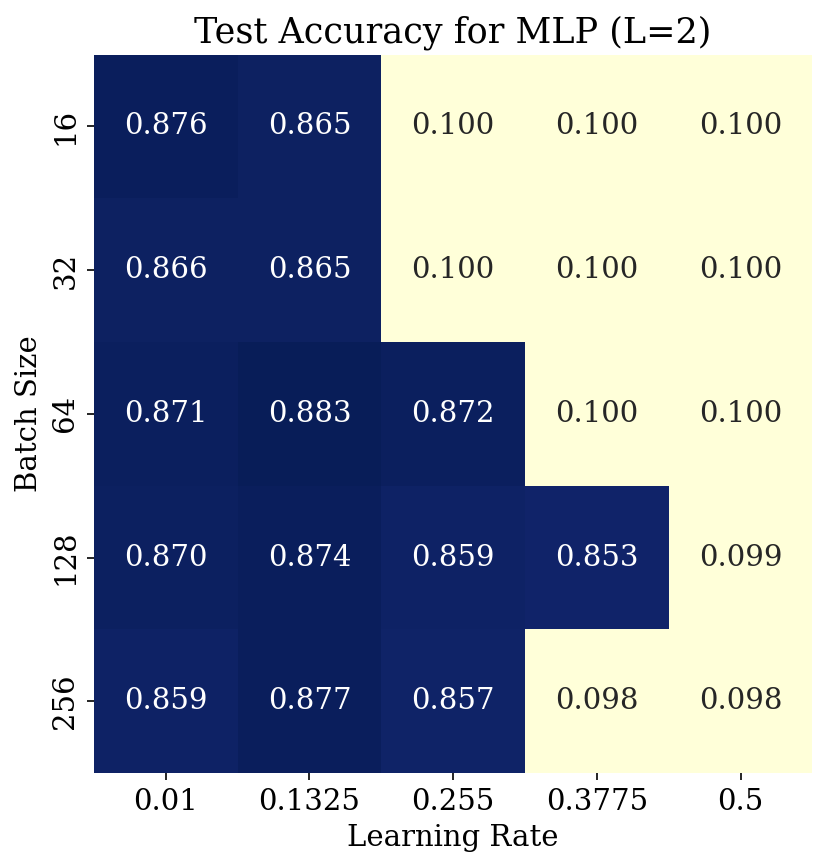

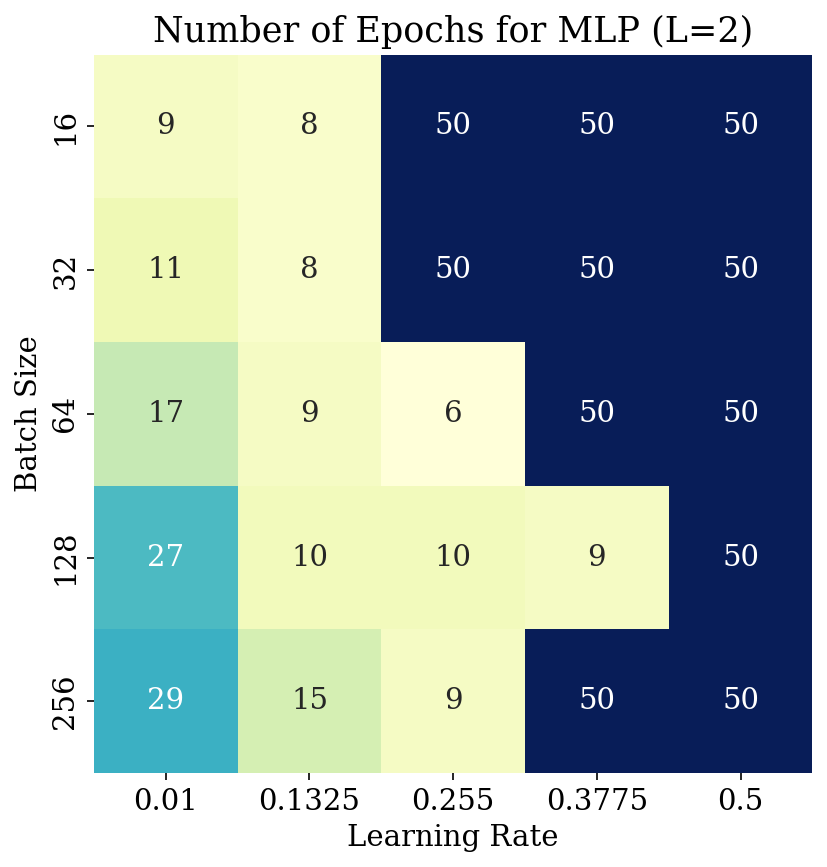

In [89]:
plot_gridsearch_results(tuning_results2, L=2, batch_range=batch_range, lr_range=lr_range)

In [90]:
# # save all model results
# with open(os.path.join(MODELDIR, 'grid_search_results.pkl'), 'wb') as f:
#     pickle.dump({
#         'help': 'Each tuning_results dict has keys as (batch_size, learning_rate) and values as [test_accuracy, num_epochs, model].',
#         'L0': tuning_results0,
#         'L0_best': best_hyper0,
#         'L1': tuning_results1,
#         'L1_best': best_hyper1,
#         'L2': tuning_results2,
#         'L2_best': best_hyper2
#     }, f)

#load later with: (see above)
# with open(os.path.join(MODELDIR, 'grid_search_results.pkl'), 'rb') as f:
#     grid_search_results = pickle.load(f)

In [91]:
# Getting optimal hyperparameters -- these will be used for all subsequent experiments
# 0 hidden layers
BATCH_SIZE0 = best_hyper0[0][0]
LEARNING_RATE0 = best_hyper0[0][1]
# 1 hidden layer
BATCH_SIZE1 = best_hyper1[0][0]
LEARNING_RATE1 = best_hyper1[0][1]
# 2 hidden layers
BATCH_SIZE2 = best_hyper2[0][0]
LEARNING_RATE2 = best_hyper2[0][1]

print(f"Optimal hyperparameters:\nL=0: Batch Size = {BATCH_SIZE0}, Learning Rate = {LEARNING_RATE0}\nL=1: Batch Size = {BATCH_SIZE1}, Learning Rate = {LEARNING_RATE1}\nL=2: Batch Size = {BATCH_SIZE2}, Learning Rate = {LEARNING_RATE2}")

Optimal hyperparameters:
L=0: Batch Size = 32, Learning Rate = 0.01
L=1: Batch Size = 256, Learning Rate = 0.1325
L=2: Batch Size = 64, Learning Rate = 0.1325


## 1 - Vary number of hidden layers

First of all, create three different models: (1) an MLP with no hidden layers, i.e., it directly maps the inputs
to outputs, (2) an MLP with a single hidden layer having 256 units and ReLU activations, (3) an MLP with 2
hidden layers each having 256 units with ReLU activations. It should be noted that since we want to perform
classification, all of these models should have a softmax layer at the end. After training, compare the test
accuracy of these three models on the FashionMNIST dataset. Comment on how non-linearity and network
depth affects the accuracy. Are the results that you obtain expected?

In [94]:
# --- 0 Hidden Layers ---
# Reload data loaders with optimal batch size
train_loader0, val_loader0, test_loader0 = get_data_loaders(
    train_dataset=train_dataset, 
    test_dataset=test_dataset, 
    val_dataset=val_dataset, 
    batch_size=BATCH_SIZE0, 
    use_validation=USE_VALIDATION
    )

# Define MLP and optimizer
model0 = MLP(
    L = 0, 
    D=28*28
    )

optimizer0 = GradientDescent(learning_rate=LEARNING_RATE0, record_grad=True)  # doing one GD iteration by batch for each epoch
num_epochs = 100

# Train model on batches
results_l0 = train_on_batches(
    model=model0, 
    optimizer=optimizer0, 
    epochs=num_epochs, 
    train_loader=train_loader0, 
    val_loader=val_loader0 if USE_VALIDATION else None, 
    early_stopping_patience=5,
    plot_train=True,
    verbose=False,
    save_fig=True, save_name='L0'
    )

KeyboardInterrupt: 

Accuracy on test set: 0.8153


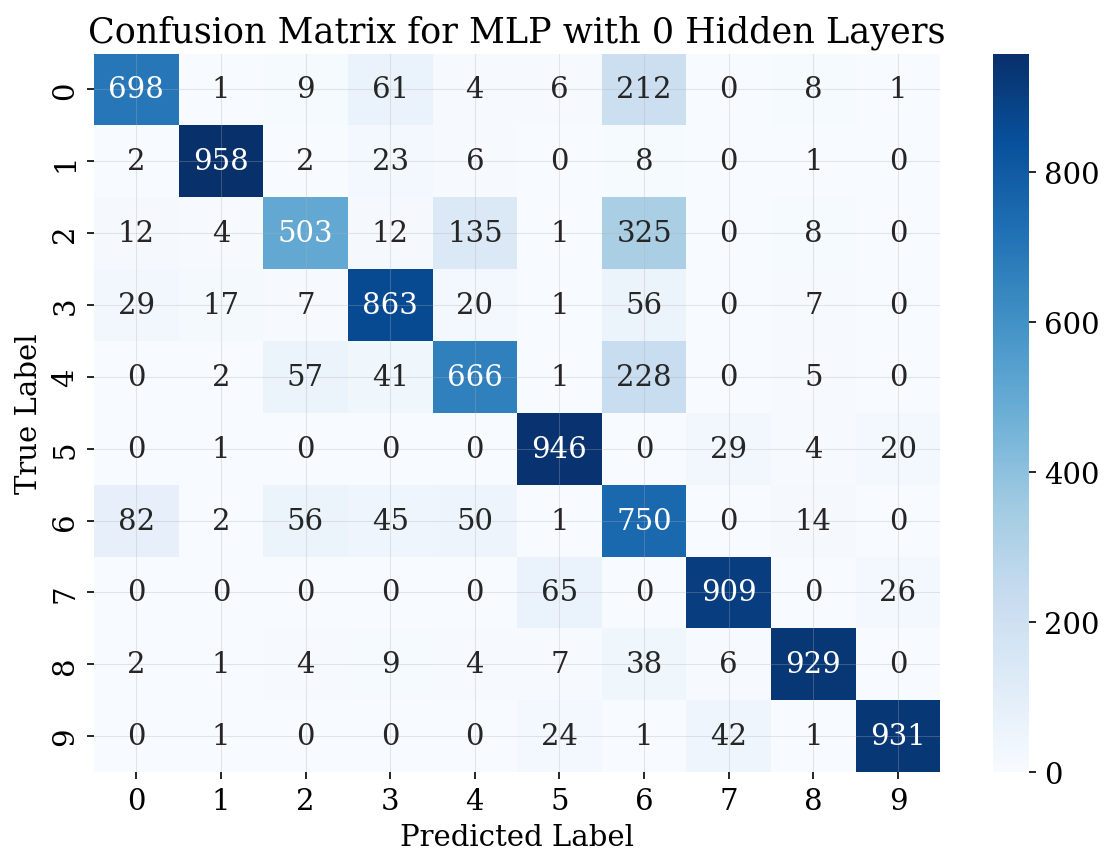

In [276]:
# Checking test predictions for first batch
test_images, test_labels = next(iter(test_loader0))
test_images = test_images.view(test_images.size(0), -1).numpy()
test_labels_onehot = np.eye(num_classes)[test_labels.numpy()]

yhat = model0.predict(test_images)  # N x C


# print("Truth:\n", np.array(test_labels), "\nPrediction:\n", np.argmax(yhat, axis=1))
print("Accuracy on test set:", evaluate_acc(test_labels_onehot, yhat))

# create confusion matrix
confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)
for true_label, pred_label in zip(test_labels.numpy(), np.argmax(yhat, axis=1)):
    confusion_matrix[true_label, pred_label] += 1
# visualize confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for MLP with 0 Hidden Layers')
plt.show()

Early stopping at epoch 13 due to no improvement in validation loss over the last 3 epochs.


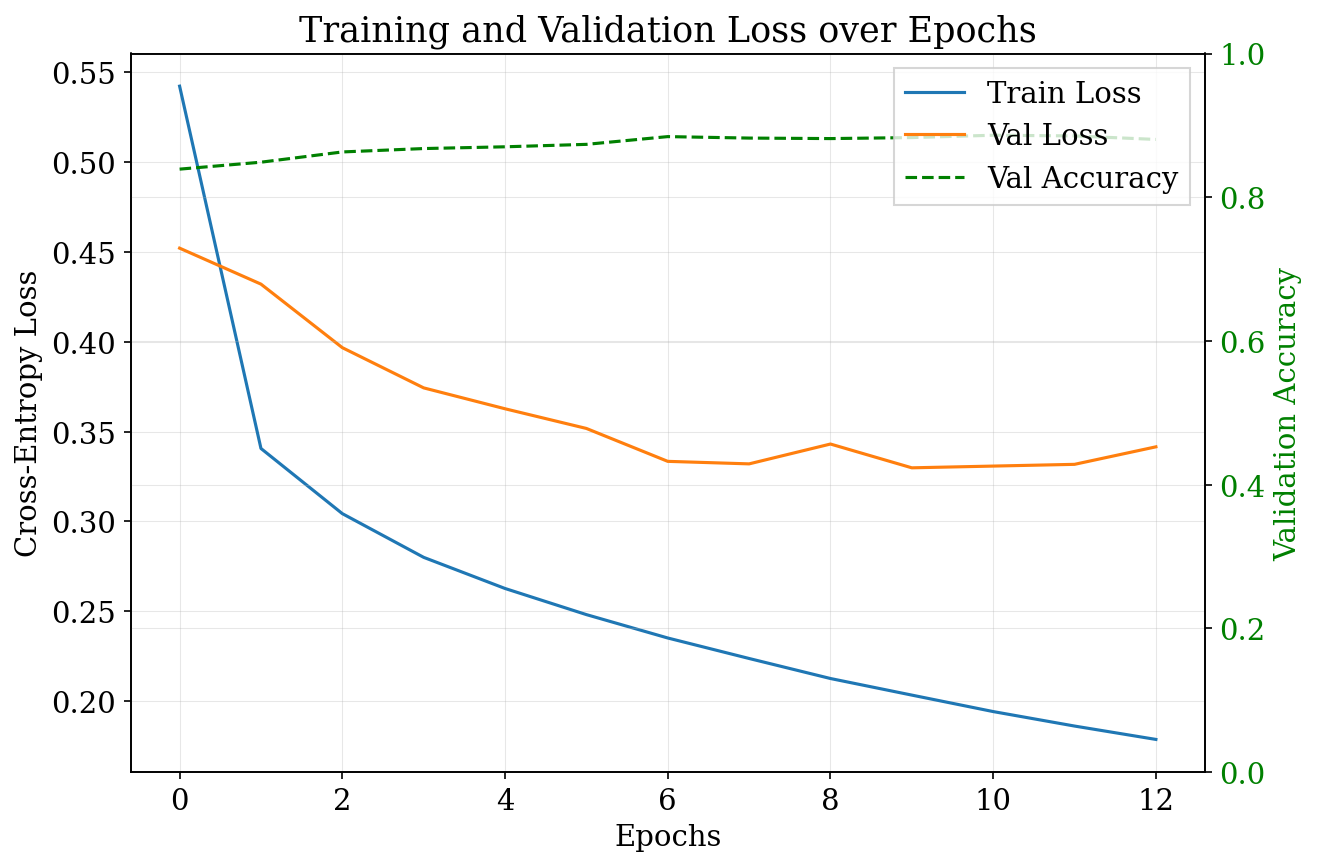

In [277]:
# --- 1 Hidden Layer ---
# Reload data loaders with optimal batch size
train_loader1, val_loader1, test_loader1 = get_data_loaders(
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    val_dataset=val_dataset,
    batch_size=BATCH_SIZE1,
    use_validation=USE_VALIDATION,
    )

# Define MLP and optimizer
model1 = MLP(
    h=relu, 
    L=1, 
    M=256,
    D=28*28
    )

optimizer1 = GradientDescent(learning_rate=LEARNING_RATE1, record_grad=True)  # doing one GD iteration by batch in one epoch
num_epochs = 100

results_l1 = train_on_batches(
    model=model1, 
    optimizer=optimizer1,
    epochs=num_epochs, 
    train_loader=train_loader1, 
    val_loader=val_loader1 if USE_VALIDATION else None, 
    early_stopping_patience=3,
    plot_train=True,
    verbose=False
    )

Accuracy on test set: 0.8678


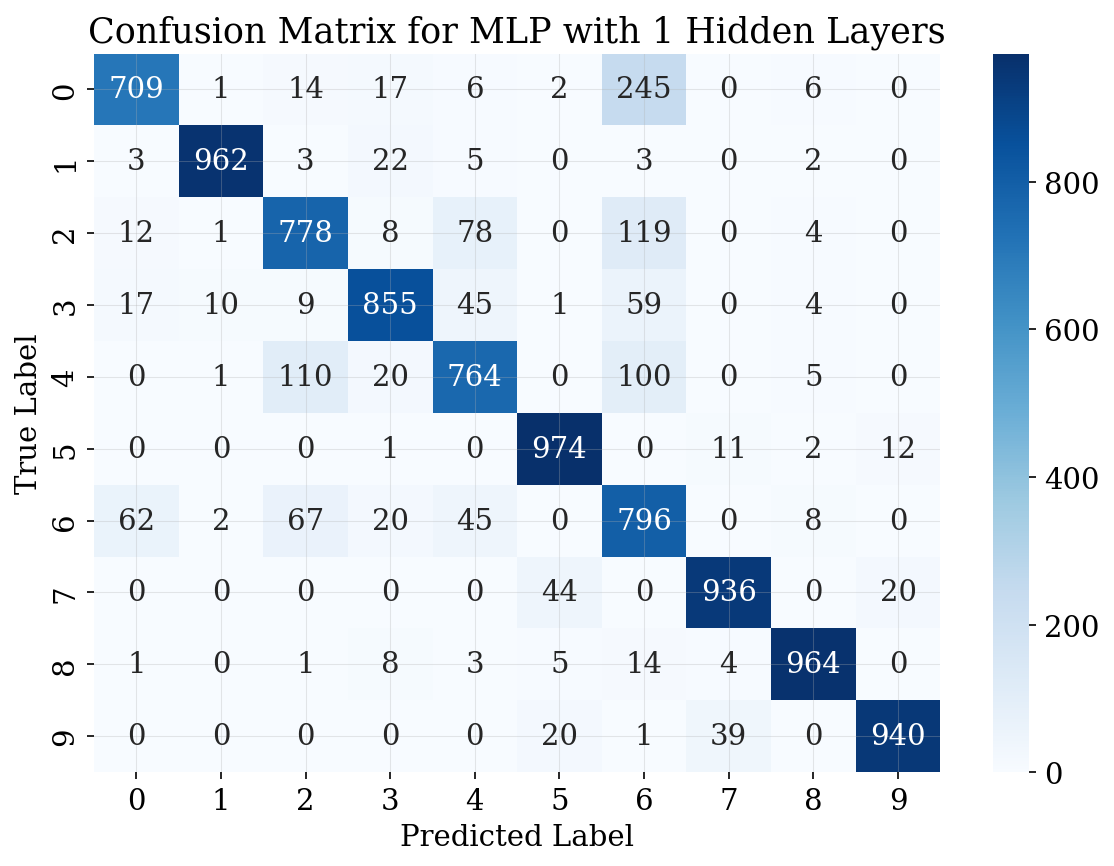

In [278]:
# Checking test predictions for first batch
test_images, test_labels = next(iter(test_loader1))
test_images = test_images.view(test_images.size(0), -1).numpy()
test_labels_onehot = np.eye(num_classes)[test_labels.numpy()]

yhat = model1.predict(test_images)  # N x C


# print("Truth:\n", np.array(test_labels), "\nPrediction:\n", np.argmax(yhat, axis=1))
print("Accuracy on test set:", evaluate_acc(test_labels_onehot, yhat))

# create confusion matrix
confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)
for true_label, pred_label in zip(test_labels.numpy(), np.argmax(yhat, axis=1)):
    confusion_matrix[true_label, pred_label] += 1
# visualize confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for MLP with 1 Hidden Layers')
plt.show()

Early stopping at epoch 10 due to no improvement in validation loss over the last 3 epochs.


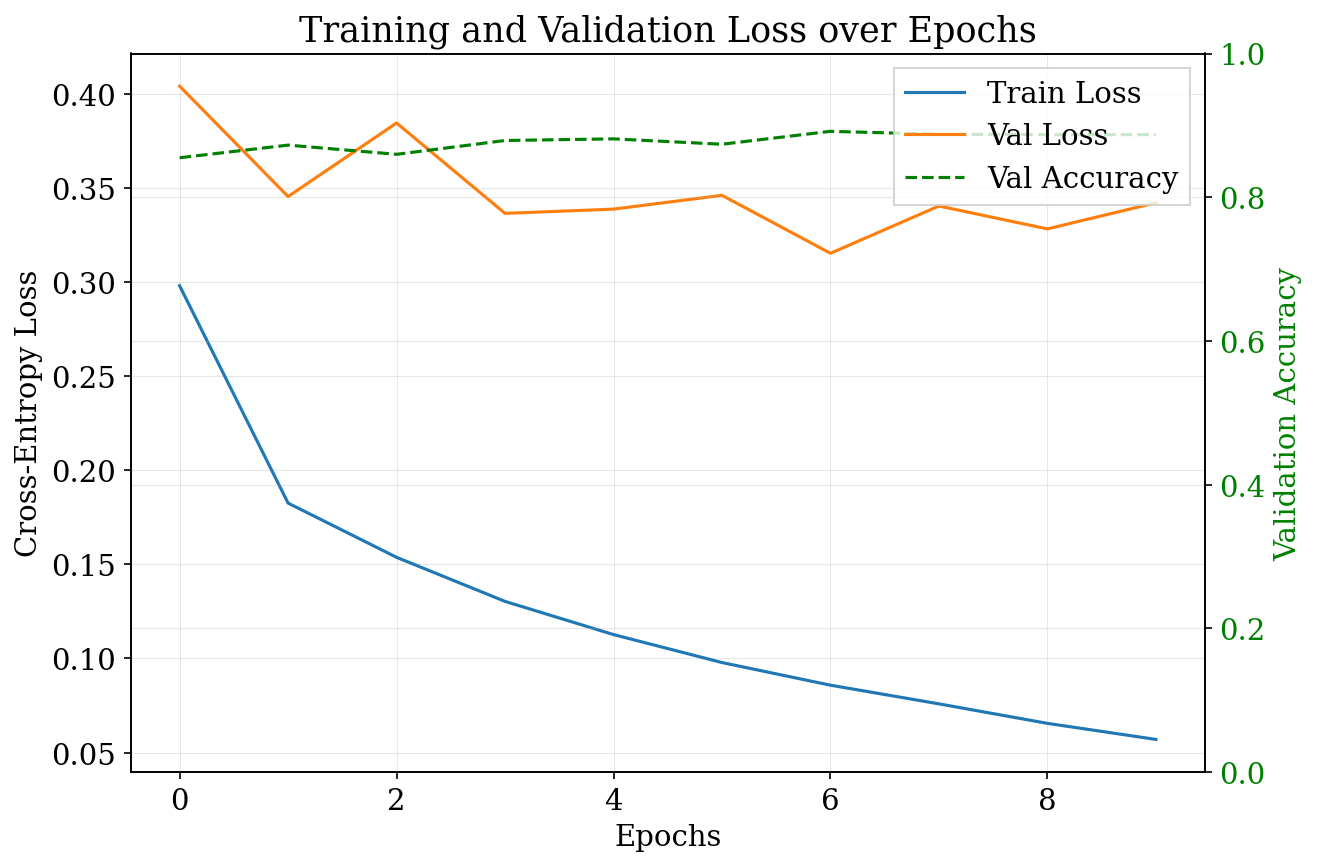

In [279]:
# --- 2 Hidden Layers ---
# Reload data loaders with optimal batch size
train_loader, val_loader, test_loader = get_data_loaders(
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    val_dataset=val_dataset,
    batch_size=BATCH_SIZE2,
    use_validation=USE_VALIDATION
    )

# Define MLP and optimizer
model2 = MLP(
    h=relu, 
    L=2, 
    M=256,
    D=28*28
    )

optimizer2 = GradientDescent(learning_rate=LEARNING_RATE2, record_grad=True)  # doing one GD iteration by batch in one epoch
num_epochs = 100

results_l2 = train_on_batches(
    model=model2, 
    optimizer=optimizer2,
    epochs=num_epochs, 
    train_loader=train_loader, 
    val_loader=val_loader if USE_VALIDATION else None, 
    early_stopping_patience=3,
    plot_train=True,
    verbose=False
    )

Accuracy on test set: 0.8719


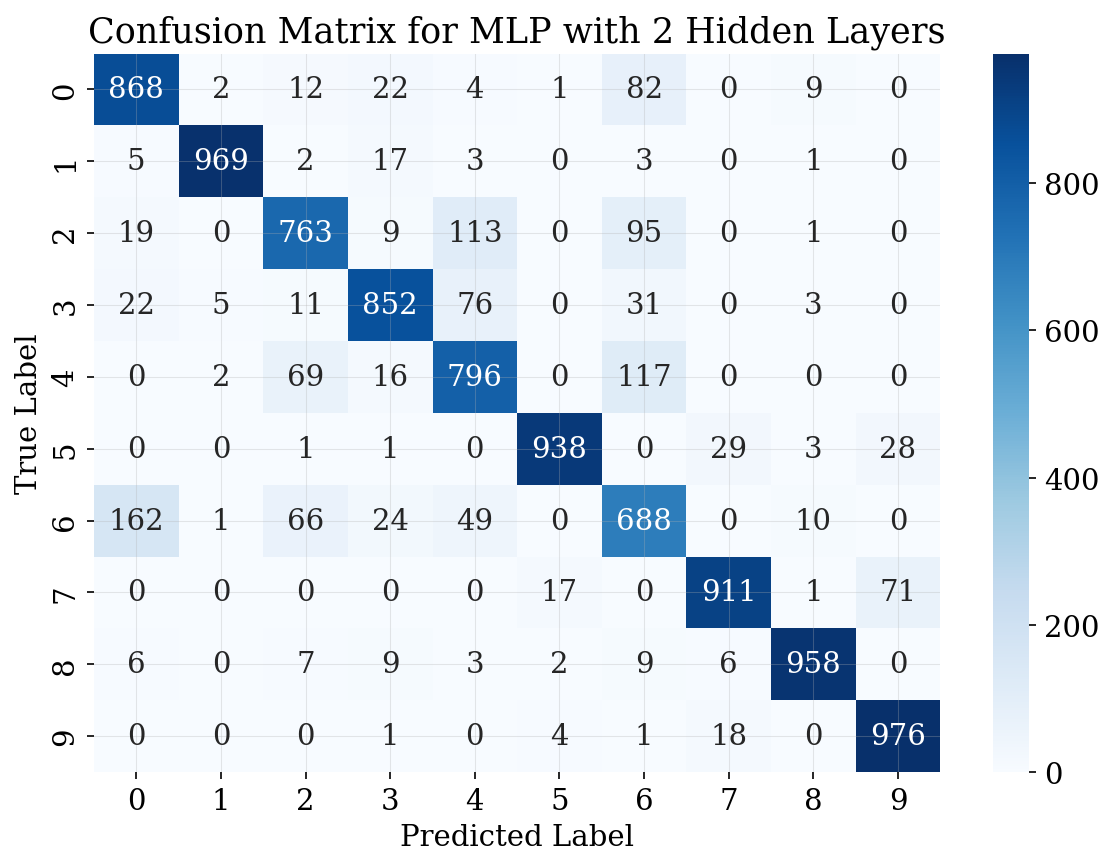

In [296]:
# Checking test predictions for first batch
test_images, test_labels = next(iter(test_loader))
test_images = test_images.view(test_images.size(0), -1).numpy()
test_labels_onehot = np.eye(num_classes)[test_labels.numpy()]

yhat = model2.predict(test_images) # N x C


# print("Truth:\n", np.array(test_labels), "\nPrediction:\n", np.argmax(yhat, axis=1))
print("Accuracy on test set:", evaluate_acc(test_labels_onehot, yhat))

# create confusion matrix
confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)
for true_label, pred_label in zip(test_labels.numpy(), np.argmax(yhat, axis=1)):
    confusion_matrix[true_label, pred_label] += 1
# visualize confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for MLP with 2 Hidden Layers')
plt.show()

In [297]:
# tabulate results of the three models
results = pd.DataFrame({
    'Model': ['MLP 0 Hidden Layers', 'MLP 1 Hidden Layers', 'MLP 2 Hidden Layers'],
    'Test Accuracy': [
        evaluate_acc(test_labels_onehot, model0.predict(test_images)),
        evaluate_acc(test_labels_onehot, model1.predict(test_images)),
        evaluate_acc(test_labels_onehot, model2.predict(test_images))
    ],
    'Epochs Trained': [
        len(results_l0['train_loss']),
        len(results_l1['train_loss']),
        len(results_l2['train_loss'])
    ]
})
results

,Model,Test Accuracy,Epochs Trained
0,MLP 0 Hidden Layers,0.8153,12
1,MLP 1 Hidden Layers,0.8678,13
2,MLP 2 Hidden Layers,0.8719,10


## 2 - Changing activations in 2-layer MLP

Take the last model above, the one with 2 hidden layers, and create two different copies of it in which the
activations are now tanh and Leaky-ReLU. After training these two models compare their test accuracies with
model having ReLU activations. Comment on the performances of these models: which one is better and why?
Are certain activations better than others? If the results are not as you expected, what could be the reason?

Early stopping at epoch 9 due to no improvement in validation loss over the last 3 epochs.


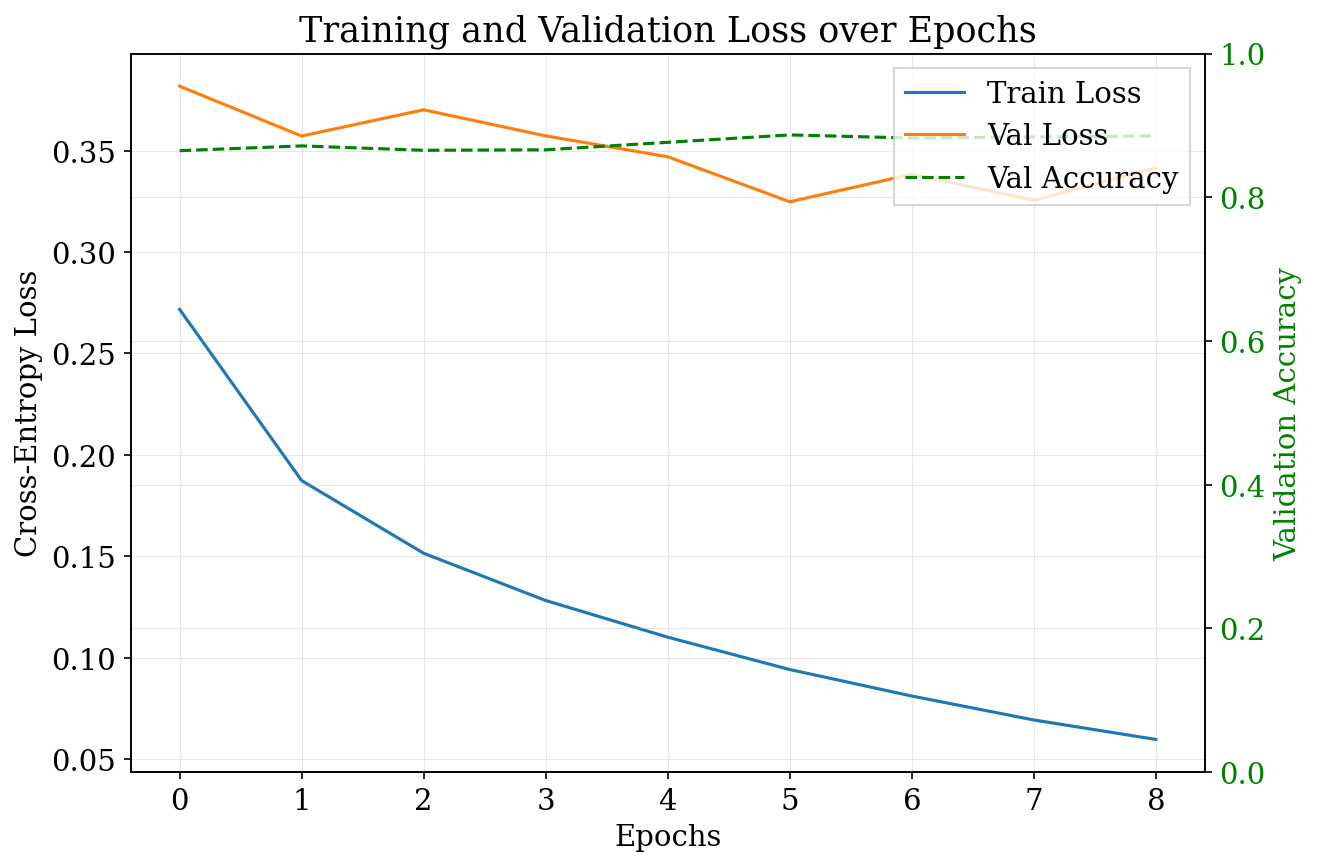

Accuracy of model with tanh: 0.8744


In [299]:
# --- 2 Hidden Layers with tanh---
model2_tanh = MLP(
    h=tanh, 
    L=2, 
    M=256,
    D=28*28
    )

optimizer2_tanh = GradientDescent(learning_rate=LEARNING_RATE2, record_grad=True)  # doing one GD iteration by batch in one epoch
num_epochs = 100

results_l2_tanh = train_on_batches(
    model=model2_tanh, 
    optimizer=optimizer2_tanh,
    epochs=num_epochs, 
    train_loader=train_loader, 
    val_loader=val_loader if USE_VALIDATION else None, 
    early_stopping_patience=3,
    plot_train=True,
    verbose=False
    )

yhat = model2_tanh.predict(test_images) # N x C
print("Accuracy of model with tanh:", evaluate_acc(test_labels_onehot, yhat))

Early stopping at epoch 11 due to no improvement in validation loss over the last 3 epochs.


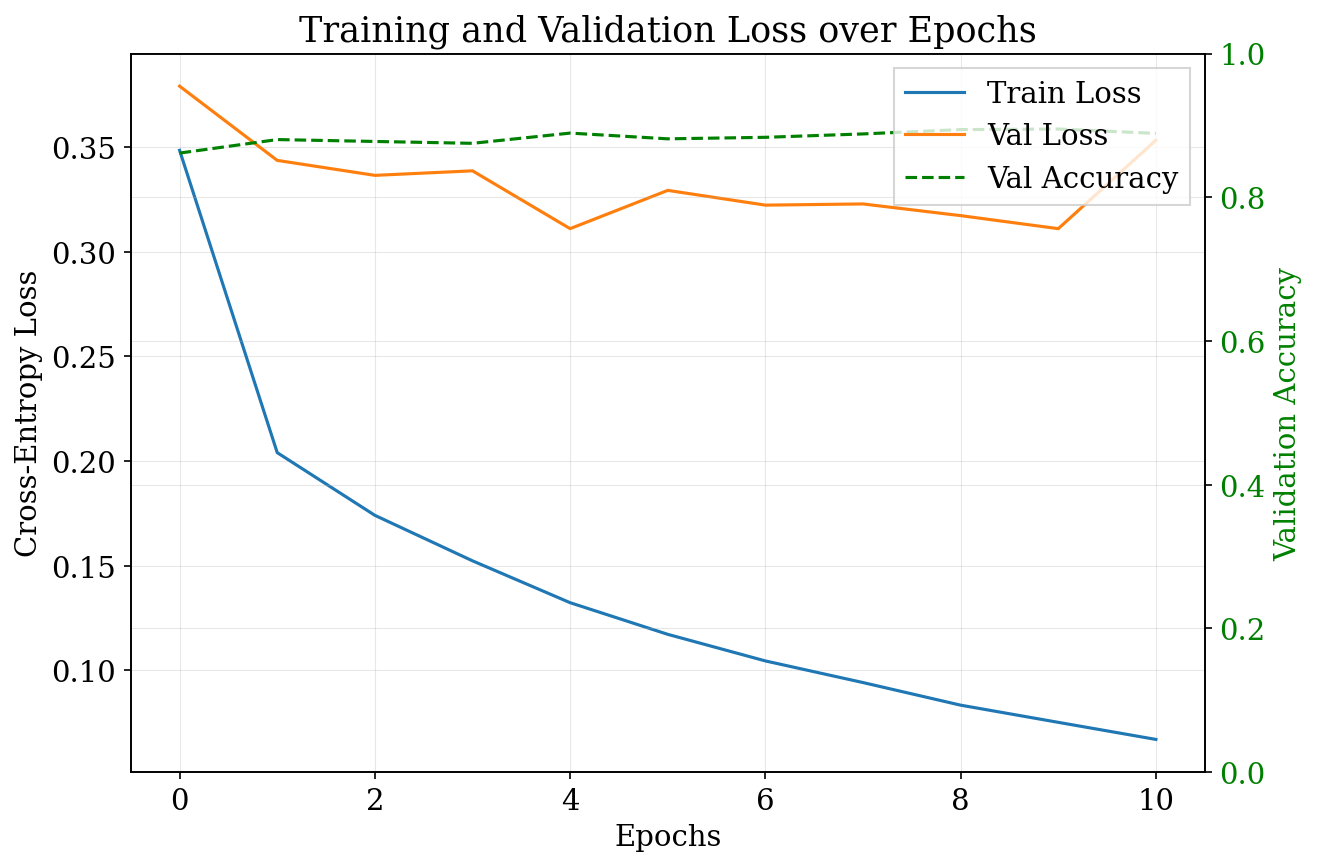

Accuracy of model with leaky relu: 0.8725


In [300]:
# --- 2 Hidden Layers with leaky ReLU ---
model2_lrelu = MLP(
    h=leaky_relu, 
    L=2, 
    M=256,
    D=28*28
    )

optimizer2_lrelu = GradientDescent(learning_rate=LEARNING_RATE2, record_grad=True)  # doing one GD iteration by batch in one epoch
num_epochs = 100

results_l2_lrelu = train_on_batches(
    model=model2_lrelu, 
    optimizer=optimizer2_lrelu,
    epochs=num_epochs, 
    train_loader=train_loader, 
    val_loader=val_loader if USE_VALIDATION else None, 
    early_stopping_patience=3,
    plot_train=True,
    verbose=False
    )

yhat = model2_lrelu.predict(test_images) # N x C
print("Accuracy of model with leaky relu:", evaluate_acc(test_labels_onehot, yhat))

In [301]:
results_part2 = pd.DataFrame({
    'Model': ['MLP 2 Hidden Layers (ReLU)', 'MLP 2 Hidden Layers (tanh)', 'MLP 2 Hidden Layers (Leaky ReLU)'],
    'Test Accuracy': [
        evaluate_acc(test_labels_onehot, model2.predict(test_images)),
        evaluate_acc(test_labels_onehot, model2_tanh.predict(test_images)),
        evaluate_acc(test_labels_onehot, model2_lrelu.predict(test_images))
    ],
    'Epochs Trained': [
        len(results_l2['train_loss']),
        len(results_l2_tanh['train_loss']),
        len(results_l2_lrelu['train_loss'])
    ]
})
results_part2

,Model,Test Accuracy,Epochs Trained
0,MLP 2 Hidden Layers (ReLU),0.8719,10
1,MLP 2 Hidden Layers (tanh),0.8744,9
2,MLP 2 Hidden Layers (Leaky ReLU),0.8725,11


## 3 - Adding regularization to 2-layer MLP

Create an MLP with 2 hidden layers each having 256 units with ReLU activations as above. However, this
time, independently add L1 and L2 regularization to the network and train the MLP in this way. How does
these regularizations affect the accuracy? This proportion can be varied as a tunable hyperparameter that can be
explored as part of other project requirements.

In [317]:
lr_range = np.linspace(0.01, 0.5, num_hyper)
reg_range = np.linspace(0.01, 0.5, num_hyper)

In [ ]:
# finding best regularization for L1 model at L=2
tuning_results2_l1reg = {} # dict to store test accuracies
epochs = 50

# get loaders for this batch size (using normalized data)
train_loader, val_loader, test_loader = get_data_loaders(train_dataset=train_dataset, 
                                                        test_dataset=test_dataset, 
                                                        val_dataset=val_dataset, 
                                                        batch_size=BATCH_SIZE2, 
                                                        use_validation=USE_VALIDATION)

for reg in reg_range:
    # loop over learning rates
    for lr in lr_range:
        # define model and optimizer (use same model params as for part 1)
        model = MLP(h=relu, L=2, M=256, D=28*28, l1_reg=reg)
        optimizer = GradientDescent(learning_rate=lr)
        
        results = train_on_batches(model, 
                                   optimizer, 
                                   epochs=epochs, 
                                   train_loader=train_loader, 
                                   val_loader=val_loader, 
                                   early_stopping_patience=5,
                                   num_classes=num_classes, 
                                   plot_train=False, 
                                   verbose=False, 
                                   save_best_weights=True)
        
        # Evaluate on test set
        test_acc = []
        for test_x, test_y in test_loader:
            test_x = test_x.view(test_x.size(0), -1).numpy()
            y_test = np.eye(num_classes)[test_y.numpy()]
            yh_test = model.predict(test_x)
            test_acc.append(evaluate_acc(y_test, yh_test))
        avg_test_acc = np.mean(test_acc)
        
        epoch = len(results["train_loss"])
        
        print(f"L1 reg: {reg:.3} Learning Rate: {lr:.3} === Test Accuracy: {avg_test_acc:.3}")
        tuning_results2_l1reg[(reg, lr)] = [avg_test_acc, epoch, model]
        
# finding best hyperparameters
best_hyper2_l1reg = max(tuning_results2_l1reg.items(), key=lambda x: x[1][0])
best_model2_l1reg = best_hyper2_l1reg[1][2]
print(f"Best hyperparameters for L=2 with L1 regularization: L1 Reg = {best_hyper2_l1reg[0][0]:.3}, Learning Rate = {best_hyper2_l1reg[0][1]:.3} with Test Accuracy = {best_hyper2_l1reg[1][0]:.3} over {best_hyper2_l1reg[1][1]} epochs")

In [ ]:
# finding best regularization for L2 model at L=2
tuning_results2_l2reg = {} # dict to store test accuracies
epochs = 50

# get loaders for this batch size (using normalized data)
train_loader, val_loader, test_loader = get_data_loaders(train_dataset=train_dataset, 
                                                        test_dataset=test_dataset, 
                                                        val_dataset=val_dataset, 
                                                        batch_size=BATCH_SIZE2, 
                                                        use_validation=USE_VALIDATION)

for reg in reg_range:
    # loop over learning rates
    for lr in lr_range:
        # define model and optimizer (use same model params as for part 1)
        model = MLP(h=relu, L=2, M=256, D=28*28, l2_reg=reg)
        optimizer = GradientDescent(learning_rate=lr)
        
        results = train_on_batches(model, 
                                   optimizer, 
                                   epochs=epochs, 
                                   train_loader=train_loader, 
                                   val_loader=val_loader, 
                                   early_stopping_patience=5,
                                   num_classes=num_classes, 
                                   plot_train=False, 
                                   verbose=False, 
                                   save_best_weights=True)
        
        # Evaluate on test set
        test_acc = []
        for test_x, test_y in test_loader:
            test_x = test_x.view(test_x.size(0), -1).numpy()
            y_test = np.eye(num_classes)[test_y.numpy()]
            yh_test = model.predict(test_x)
            test_acc.append(evaluate_acc(y_test, yh_test))
        avg_test_acc = np.mean(test_acc)
        
        epoch = len(results["train_loss"])
        
        print(f"L2 reg: {reg:.3} Learning Rate: {lr:.3} === Test Accuracy: {avg_test_acc:.3}")
        tuning_results2_l2reg[(reg, lr)] = [avg_test_acc, epoch, model]
        
# finding best hyperparameters
best_hyper2_l2reg = max(tuning_results2_l2reg.items(), key=lambda x: x[1][0])
best_model2_l2reg = best_hyper2_l2reg[1][2]
print(f"Best hyperparameters for L=2 with L2 regularization: L2 Reg = {best_hyper2_l2reg[0][0]:.3}, Learning Rate = {best_hyper2_l2reg[0][1]:.3} with Test Accuracy = {best_hyper2_l2reg[1][0]:.3} over {best_hyper2_l2reg[1][1]} epochs")

In [ ]:
# save all model results
with open(os.path.join(MODELDIR, 'regularization_grid_search_results.pkl'), 'wb') as f:
    pickle.dump({
        'help': 'Each tuning_results dict has keys as (regularization coefficient, learning_rate) and values as [test_accuracy, num_epochs, model].',
        'L1_reg': tuning_results2_l1reg,
        'L1_reg_best': best_hyper2_l1reg,
        'L2_reg': tuning_results2_l2reg,
        'L2_reg_best': best_hyper2_l2reg
    }, f)

#load later with: (see above)
# with open(os.path.join(MODELDIR, 'grid_search_results.pkl'), 'rb') as f:
#     grid_search_results = pickle.load(f)

In [ ]:
L1_REG_BEST = best_hyper2_l1reg[0][0]
L2_REG_BEST = best_hyper2_l2reg[0][0]

Early stopping at epoch 23 due to no improvement in validation loss over the last 5 epochs.


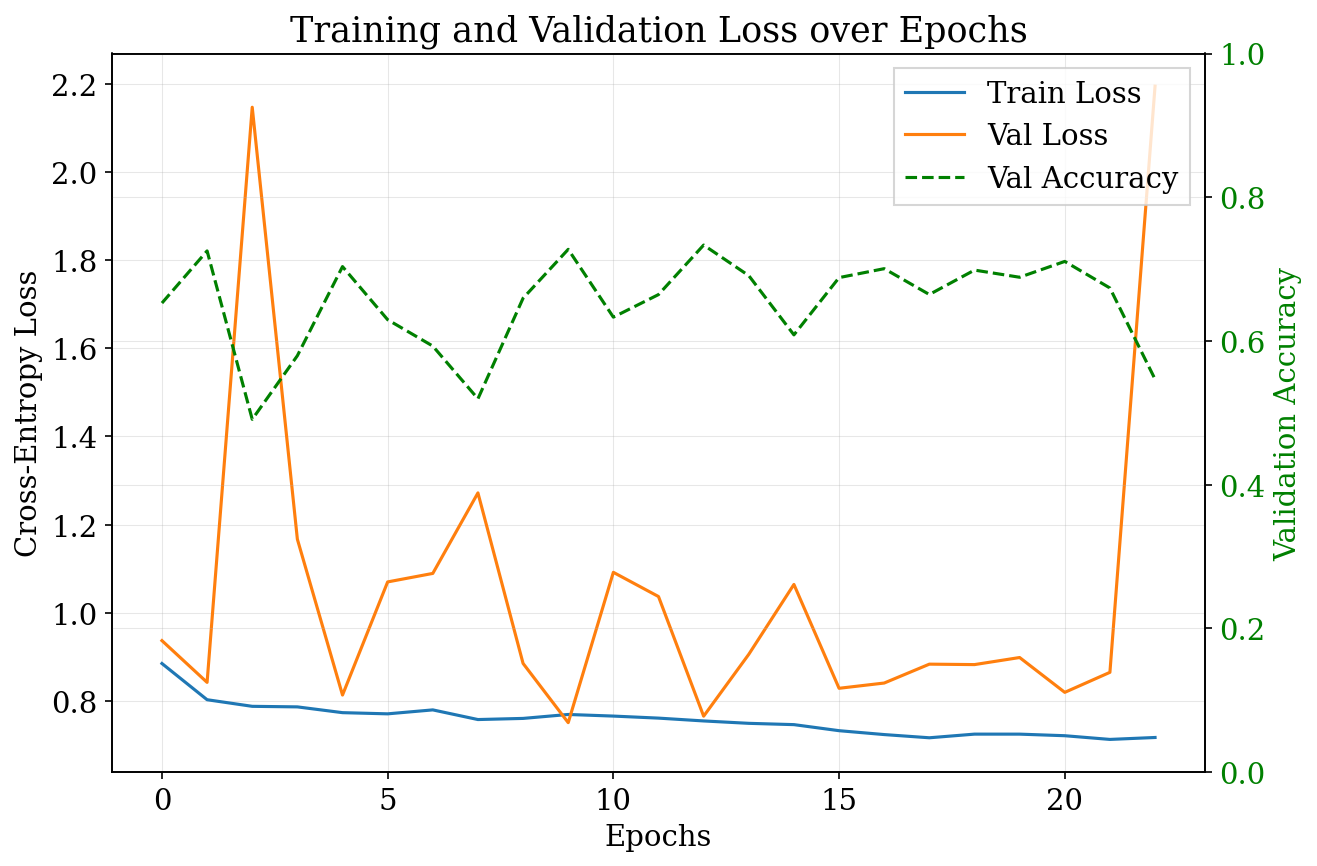

Accuracy of model with L1 regularization: 0.5487


In [ ]:
# --- 2 Hidden Layers with L1 regularization ---
model2_l1reg = MLP(
    h=relu, 
    L=2, 
    M=256,
    D=28*28,
    l1_reg=L1_REG_BEST
    )

optimizer2_l1reg = GradientDescent(learning_rate=LEARNING_RATE2, record_grad=True)  # doing one GD iteration by batch in one epoch
num_epochs = 50

results_l2_l1reg = train_on_batches(
    model=model2_l1reg, 
    optimizer=optimizer2_l1reg,
    epochs=num_epochs, 
    train_loader=train_loader, 
    val_loader=val_loader if USE_VALIDATION else None, 
    early_stopping_patience=5,
    plot_train=True,
    verbose=False
    )

yhat = model2_l1reg.predict(test_images) # N x C
print("Accuracy of model with L1 regularization:", evaluate_acc(test_labels_onehot, yhat))

Accuracy on test set: 0.5487


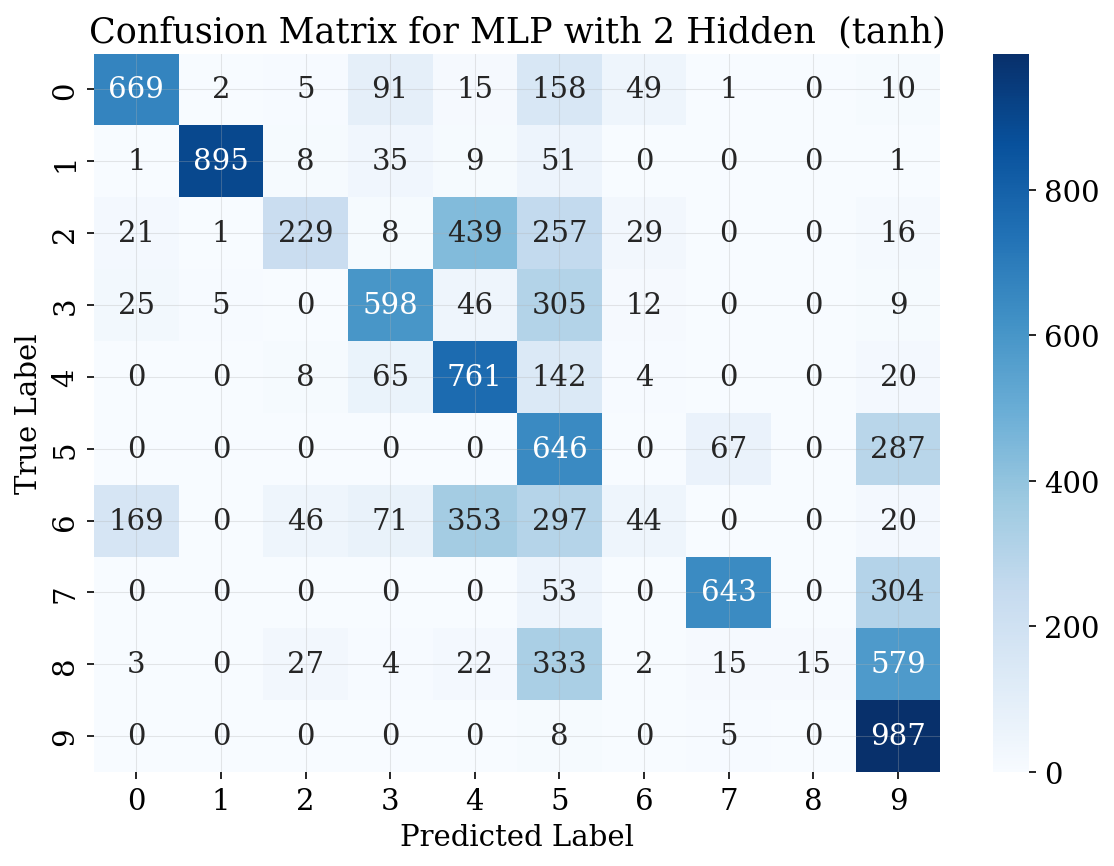

In [ ]:
yhat = model2_l1reg.predict(test_images) # N x C

# print("Truth:\n", np.array(test_labels), "\nPrediction:\n", np.argmax(yhat, axis=1))
print("Accuracy on test set:", evaluate_acc(test_labels_onehot, yhat))

# create confusion matrix
confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)
for true_label, pred_label in zip(test_labels.numpy(), np.argmax(yhat, axis=1)):
    confusion_matrix[true_label, pred_label] += 1
# visualize confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for MLP with 2 Hidden  (tanh)')
plt.show()

Early stopping at epoch 11 due to no improvement in validation loss over the last 10 epochs.


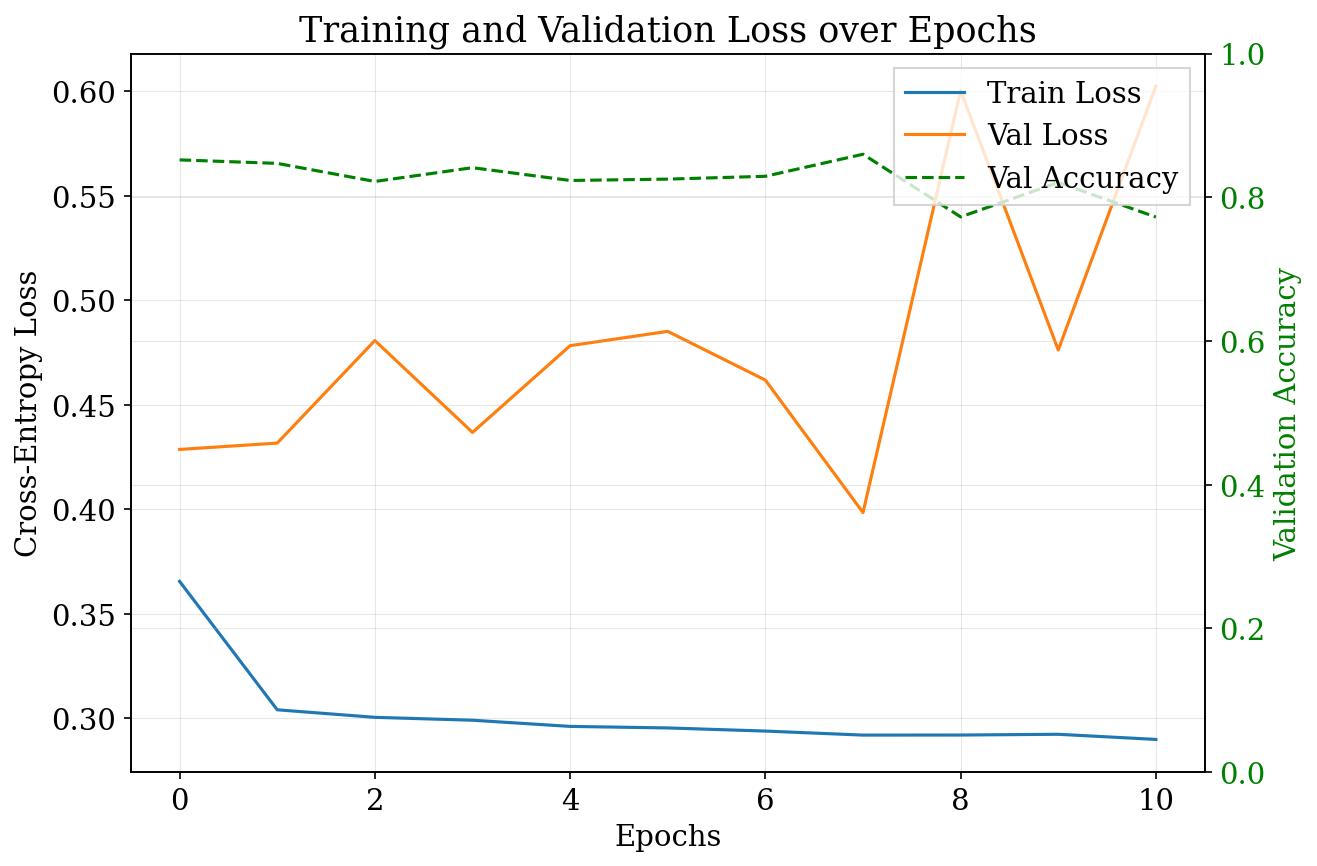

Accuracy of model with L2 regularization: 0.7668


In [ ]:
 # --- 2 Hidden Layers with L2 regularization ---
model2_l2reg = MLP(
    h=relu, 
    L=2, 
    M=256,
    D=28*28,
    l2_reg=L2_REG_BEST
    )

optimizer2_l2reg = GradientDescent(learning_rate=LEARNING_RATE2, record_grad=True)  # doing one GD iteration by batch in one epoch
num_epochs = 50

results_l2_l2reg = train_on_batches(
    model=model2_l2reg, 
    optimizer=optimizer2_l2reg,
    epochs=num_epochs, 
    train_loader=train_loader, 
    val_loader=val_loader if USE_VALIDATION else None, 
    early_stopping_patience=10,
    plot_train=True,
    verbose=False
    )

yhat = model2_l2reg.predict(test_images) # N x C
print("Accuracy of model with L2 regularization:", evaluate_acc(test_labels_onehot, yhat))

In [ ]:
results_part3 = pd.DataFrame({
    'Model': ['MLP 2 Hidden Layers (ReLU)', 'MLP 2 Hidden Layers with L1 reg (ReLU)', 'MLP 2 Hidden Layers with L2 reg (ReLU)'],
    'Test Accuracy': [
        evaluate_acc(test_labels_onehot, model2.predict(test_images)),
        evaluate_acc(test_labels_onehot, model2_l1reg.predict(test_images)),
        evaluate_acc(test_labels_onehot, model2_l2reg.predict(test_images))
    ],
    'Epochs Trained': [
        len(results_l2['train_loss']),
        len(results_l2_l1reg['train_loss']),
        len(results_l2_l2reg['train_loss'])
    ]
})
results_part3

,Model,Test Accuracy,Epochs Trained
0,MLP 2 Hidden Layers (ReLU),0.8719,10
1,MLP 2 Hidden Layers with L1 reg (ReLU),0.5487,23
2,MLP 2 Hidden Layers with L2 reg (ReLU),0.7668,11


## 4 - Unnormalized 2-layer MLP

Create an MLP with 2 hidden layers each having 256 units with ReLU activations as above. However, this time,
train it with unnormalized images. How does this affect the accuracy?

In [306]:
train_unnorm, val_unnorm, test_unnorm = get_datasets(USE_VALIDATION, transform=transforms.ToTensor())
train_loader_unnorm, val_loader_unnorm, test_loader_unnorm = get_data_loaders(train_unnorm, test_unnorm, val_unnorm, BATCH_SIZE2, USE_VALIDATION)

Early stopping at epoch 10 due to no improvement in validation loss over the last 4 epochs.


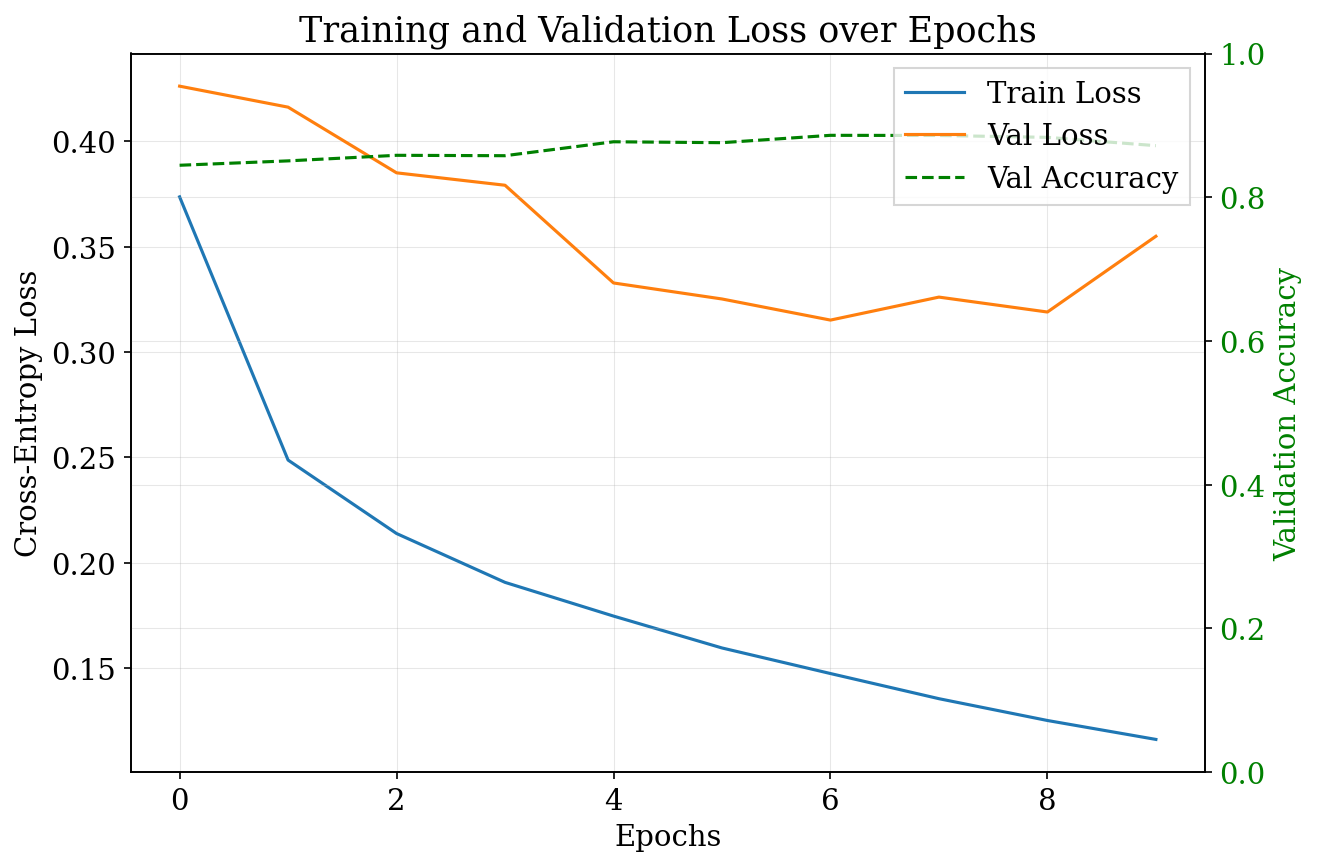

Accuracy of model without normalization: 0.84375


In [307]:
# train MLP with L=2 on the unnormalized data
model2_unnorm = MLP(
    h=relu, 
    L=2, 
    M=256,
    D=28*28
)

optimizer2_unnorm = GradientDescent(learning_rate=LEARNING_RATE2, record_grad=True)  # doing one GD iteration by batch in one epoch
num_epochs = 50

results_l2_unnorm = train_on_batches(
    model=model2_unnorm, 
    optimizer=optimizer2_unnorm,
    epochs=num_epochs, 
    train_loader=train_loader_unnorm, 
    val_loader=val_loader_unnorm if USE_VALIDATION else None, 
    early_stopping_patience=4,
    plot_train=True,
    verbose=False
    )

# Checking test predictions for first batch
test_images, test_labels = next(iter(test_loader_unnorm))
test_images = test_images.view(test_images.size(0), -1).numpy()
test_labels_onehot = np.eye(num_classes)[test_labels.numpy()]
yhat = model2_unnorm.predict(test_images) # N x C

print("Accuracy of model without normalization:", evaluate_acc(test_labels_onehot, yhat))

## 5 - Data augmentation

Re-train the MLP from question 3 on a version of FashionMNIST using data augmentation. You can use the
transforms.Compose() function to set your transformations for data augmentation, and the
transform=train transform argument in the dataset constructor to set the transforms. Is the accuracy
affected, and how? What are the benefits and/or drawbacks of using data augmentation? Can you think of a
situation in which certain types data augmentation would be harmful?

In [310]:
augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),  # rotate by +/- 10 degrees
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,))
])

# We do not crop since images are small (28x28) AND cropping may remove important features for classification

train_aug, val_aug, test_aug = get_datasets(USE_VALIDATION, transform=augmentation_transforms)
train_loader_aug, val_loader_aug, test_loader_aug = get_data_loaders(train_aug, val_aug, test_aug, BATCH_SIZE2, USE_VALIDATION)

In [314]:
# get test images
test_images_aug, test_labels_aug = next(iter(test_loader_aug))
test_images_aug = test_images_aug.view(test_images_aug.size(0), -1).numpy()
test_labels_onehot_aug = np.eye(num_classes)[test_labels_aug.numpy()]

Early stopping at epoch 9 due to no improvement in validation loss over the last 5 epochs.


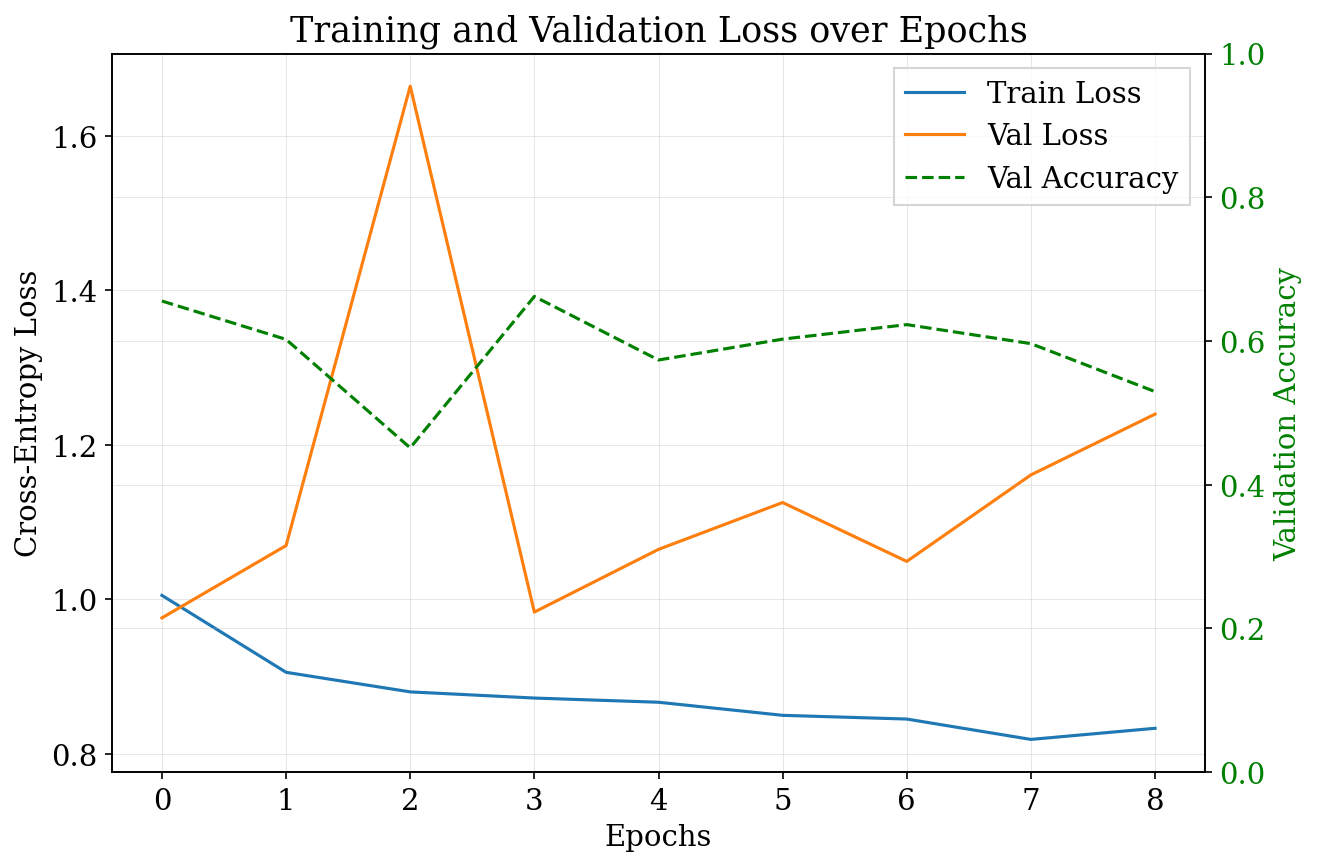

Accuracy of model with L1 regularization: 0.125


In [315]:
# --- 2 Hidden Layers with L1 regularization ---
model2_l1reg_aug = MLP(
    h=relu, 
    L=2, 
    M=256,
    D=28*28,
    l1_reg=0.01
    )

optimizer2_l1reg_aug = GradientDescent(learning_rate=LEARNING_RATE2, record_grad=True)  # doing one GD iteration by batch in one epoch
num_epochs = 50

results_l2_l1reg_aug = train_on_batches(
    model=model2_l1reg_aug, 
    optimizer=optimizer2_l1reg_aug,
    epochs=num_epochs, 
    train_loader=train_loader_aug, 
    val_loader=val_loader_aug if USE_VALIDATION else None, 
    early_stopping_patience=5,
    plot_train=True,
    verbose=False
    )

yhat = model2_l1reg_aug.predict(test_images) # N x C
print("Accuracy of model with L1 regularization:", evaluate_acc(test_labels_onehot_aug, yhat))

In [316]:
 # --- 2 Hidden Layers with L2 regularization ---
model2_l2reg_aug = MLP(
    h=relu, 
    L=2, 
    M=256,
    D=28*28,
    l2_reg=0.01
    )

optimizer2_l2reg_aug = GradientDescent(learning_rate=LEARNING_RATE2, record_grad=True)  # doing one GD iteration by batch in one epoch
num_epochs = 50

results_l2_l2reg_aug = train_on_batches(
    model=model2_l2reg_aug, 
    optimizer=optimizer2_l2reg_aug,
    epochs=num_epochs, 
    train_loader=train_loader_aug, 
    val_loader=val_loader_aug if USE_VALIDATION else None, 
    early_stopping_patience=10,
    plot_train=True,
    verbose=False
    )

yhat = model2_l2reg_aug.predict(test_images_aug) # N x C
print("Accuracy of model with L2 regularization:", evaluate_acc(test_labels_onehot_aug, yhat))

KeyboardInterrupt: 

# CNN Experiments

NOTE: A basic hyperparameter search (e.g. learning rate, batch size, etc.) is required. If you want to do a more extensive search on the model architecture (number of filters, kernel size, stride, padding, etc.) that would count as a creative experiment.

## 6 - Create a CNN

Using existing libraries such as TensorFlow or PyTorch, create a convolutional neural network (CNN) with 2
convolutional layers, one fully connected hidden layer and one fully connected output layer. Although you
are free in your choice of the hyperparameters of the convolutional layers, set the number of units in the fully
connected layers to be 256. Also, set the activations in all of the layers to be ReLU. Train this CNN on the
FashionMNIST dataset. Does using a CNN increase/decrease the accuracy compared to using MLPs? Provide
comments on your results.

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) #can change kernel and padding

        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128) # depends on kernel size and padding
        self.fc2 = nn.Linear(128, num_classes)

        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        x = x.view(-1, 64 * 7 * 7) # flatten

        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        x = self.fc2(x)
        return x

# Checking if GPU is available   
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)
    
model = CNN()
model.to(device)

optimizer = Adam(model.parameters(), learning_rate=0.001)

## 7 - Data augmentation

Train the above CNN using FashionMNIST with the data augmentation from Q5. How is the performance
(accuracy and speed) affected?

## 8 - Pre-trained model

Load a pre-trained model that you see fit (e.g., a ResNet) using existing libraries such as TensorFlow or PyTorch,
and then freeze all the convolutional layers and remove all the fully connected ones. Add a number of fully
connected layers of your choice right after the convolutional layers. Train only the fully connected layers of the
pre-trained model on the FashionMNIST dataset with the data augmentation from Q5. How does this pre-trained
model compare to the best MLP in part 5 and to the CNN in part 7 in terms of accuracy? How does it compare
to the previous models in terms of the required training time? Justify your choice of how many fully connected
layers that you have added to the pre-trained model through careful experiments.